In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os import path
import json
import os
from pandas.tseries.offsets import MonthEnd
from plotting import * 
import modify_dataset  
from itertools import combinations
from scipy.stats import entropy
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import matplotlib.patheffects as pe
import itertools
from sklearn.cluster import AgglomerativeClustering, SpectralClustering
from scipy.cluster.hierarchy import fcluster
from sklearn import metrics
import skbio.stats.distance as ssd
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

In [153]:
def add_mid_year_column(df): 
    months = df["Date"].dt.month
    df["Mid_year"] = ["Summer" if 4 <= month <= 9 else "Winter" for month in months]
    return df

In [3]:
def build_linkage_matrix(model) -> np.ndarray : 
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    return np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

In [4]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [5]:
def plot_season_membership(abund_dataframe): 
    fig, axs = plt.subplots(2, 2, figsize = (15, 15))
    axs = axs.flatten()
    methods = ["ward_7", "ward_8", "ward_9", "ward_10"]
    for (ax, method) in zip(axs, methods): 
        n_samples_month_season = abund_dataframe.groupby(["Season", "Date"], observed=True).agg({"id" : "nunique", "Month" : "first"}).reset_index().groupby(["Season", "Month"], observed=True)["id"].sum()
        n_samples_cluster_month_season = abund_dataframe.groupby([method, "Season", "Date"], observed=True).agg({"id" : "nunique", "Month" : "first"}).reset_index().groupby([method, "Season", "Month"], observed=True)["id"].sum()
        clust_subdivision = n_samples_cluster_month_season.div(n_samples_month_season).reset_index().sort_values([method, "Season", "Month"]).pivot_table(index = method, columns = ["Season", "Month"], values = "id", observed=True).T
        n_samples_cluster = abund_dataframe.drop_duplicates([method, "Date", "id"]).groupby(method, observed=True)["Date"].count()
        n_samples_group = abund_dataframe.drop_duplicates(["Date", "id"]).groupby(["Season", "Month"], observed=True)["Date"].count()
        p = sns.heatmap(clust_subdivision, 
                    ax = ax, 
                    cmap = plt.get_cmap("viridis"),
                    #norm = norm, 
                    cbar = False, 
                    annot=True, 
                    fmt=".2f", 
                    yticklabels=[f"{Region}-{Season}" for Region, Season in clust_subdivision.index])
        w = ax.get_xticks()
        v = ax.get_yticks()
        delta_xtick = w[1] - w[0] 
        ax.vlines([i + delta_xtick / 2 for i in w], 0, 59, linestyles = "--", colors = "k", alpha = 0.5, linewidth = 0.5)
        ax.vlines([i - delta_xtick / 2 for i in w[1:]], 0, 50, linestyles = "--", colors = "k", alpha = 0.5, linewidth = 0.5)
        ax.vlines(0, 0, 59, linestyles = "-", colors = "black", linewidths = 1)
        ax.hlines([(i + j) / 2 for i, j in zip(v, v[1:])], 0, 59, linestyles = "--", colors = "k", alpha = 0.5, linewidth = 0.5)
        ax.set_xticklabels([f"{n}\n({samples})" for (n, samples) in zip(n_samples_cluster.index, n_samples_cluster.to_numpy())])
        ax.set_yticklabels([f"{Region}-{Season} ({count})" for (Region, Season), count in zip(n_samples_group.index, n_samples_group.to_numpy())])
        ax.set_title(str.split(method, "_")[-1] + " clusters", size = 15)
        ax.set_xlabel("")
        ax.set_ylabel("")
    plt.tight_layout(rect = [0,0,1,0.97]);
    plt.suptitle("Membership of months to each cluster", size = 20)
    #plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Clustering/Results/Spec_month_to_cluster_spectral.png", bbox_inches = "tight");

In [6]:
def plot_season_specificity(abund_dataframe): 
    fig, axs = plt.subplots(2, 2, figsize = (15, 15))
    axs = axs.flatten()
    methods = ["ward_7", "ward_8", "ward_9", "ward_10"]
    for (ax, method) in zip(axs, methods): 
        n_samples_cluster = abund_dataframe.drop_duplicates([method, "Date", "id"]).groupby(method)["id"].count()
        n_samples_cluster_month_season = abund_dataframe.groupby([method, "Season", "Date"], observed=True).agg({"id" : "nunique", "Month" : "first"}).reset_index().groupby([method, "Season", "Month"], observed=True)["id"].sum()
        clust_subdivision = n_samples_cluster_month_season.div(n_samples_cluster).reset_index().sort_values([method, "Season", "Month"]).pivot_table(index = method, columns = ["Season", "Month"], values = "id", observed = True).T
        n_samples_group = abund_dataframe.drop_duplicates(["Date", "id"]).groupby(["Season", "Month"], observed=True)["id"].count()
        sns.heatmap(clust_subdivision, 
                    ax = ax, 
                    cmap = plt.get_cmap("cividis"),
                    #norm = norm, 
                    cbar = False, 
                    annot=True, 
                    fmt=".2f", 
                    yticklabels=[f"{Region}-{Season}" for Region, Season in clust_subdivision.index]
                    )
        w = ax.get_xticks()
        v = ax.get_yticks()
        delta_xtick = w[1] - w[0] 
        ax.vlines([i + delta_xtick / 2 for i in w], 0, 59, linestyles = "--", colors = "k", alpha = 0.5, linewidth = 0.5)
        ax.vlines([i - delta_xtick / 2 for i in w[1:]], 0, 50, linestyles = "--", colors = "k", alpha = 0.5, linewidth = 0.5)
        ax.vlines(0, 0, 59, linestyles = "-", colors = "black", linewidths = 1)
        ax.hlines([(i + j) / 2 for i, j in zip(v, v[1:])], 0, 59, linestyles = "--", colors = "k", alpha = 0.5, linewidth = 0.5)
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels([f"{n}\n({samples})" for (n, samples) in zip(n_samples_cluster.index, n_samples_cluster.to_numpy())])
        ax.set_yticklabels([f"{Region}-{Season} ({count})" for (Region, Season), count in zip(n_samples_group.index, n_samples_group.to_numpy())])
        ax.set_title(str.split(method, "_")[-1] + " clusters", size = 15)
        ax.set_xlabel("")
        ax.set_ylabel("")
    plt.tight_layout(rect = [0,0,1,0.97]);
    plt.suptitle("Specificity of clusters to each month", size = 20)

In [7]:
def plot_region_membership(abund_dataframe): 
    fig, axs = plt.subplots(2, 2, figsize = (15, 15))
    axs = axs.flatten()
    methods = ["ward_7", "ward_8", "ward_9", "ward_10"]
    for (ax, method) in zip(axs, methods): 
        n_samples_region = abund_dataframe.groupby(["Region", "Date"], observed=True).agg({"id" : "nunique"}).reset_index().groupby("Region", observed=True)["id"].sum()
        n_samples_cluster_region = abund_dataframe.groupby([method, "Region", "Date"], observed=True).agg({"id" : "nunique"}).reset_index().groupby([method, "Region"], observed=True)["id"].sum()
        clust_subdivision = n_samples_cluster_region.div(n_samples_region).reset_index().sort_values([method, "Region"]).pivot_table(index = method, columns = "Region",  values = "id", observed = True).T    
        n_samples_cluster = abund_dataframe.drop_duplicates([method, "Date", "id"]).groupby(method)["Date"].count()
        n_samples_group = abund_dataframe.drop_duplicates(["Date", "id"]).groupby("Region", observed=True)["Date"].count()
        sns.heatmap(clust_subdivision, 
                    ax = ax, 
                    cmap = plt.get_cmap("viridis"),
                    #norm = norm, 
                    cbar = False, 
                    annot=True, 
                    fmt=".2f"
                    )
        w = ax.get_xticks()
        v = ax.get_yticks()
        delta_xtick = w[1] - w[0] 
        ax.vlines([i + delta_xtick / 2 for i in w], 0, 59, linestyles = "--", colors = "k", alpha = 0.5, linewidth = 0.5)
        ax.vlines([i - delta_xtick / 2 for i in w[1:]], 0, 50, linestyles = "--", colors = "k", alpha = 0.5, linewidth = 0.5)
        ax.vlines(0, 0, 59, linestyles = "-", colors = "black", linewidths = 1)
        ax.hlines([(i + j) / 2 for i, j in zip(v, v[1:])], 0, 59, linestyles = "--", colors = "k", alpha = 0.5, linewidth = 0.5)
        ax.set_xticklabels([f"{n}\n({samples})" for (n, samples) in zip(n_samples_cluster.index, n_samples_cluster.to_numpy())])
        ax.set_yticklabels([f"{Region} ({count})" for Region, count in zip(n_samples_group.index, n_samples_group.to_numpy())])
        ax.set_title(str.split(method, "_")[-1] + " clusters", size = 15)
        ax.set_xlabel("")
        ax.set_ylabel("")
    plt.tight_layout(rect = [0,0,1,0.97]);
    plt.suptitle("Membership of regions to each cluster", size = 20)
    #plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Clustering/Results/Spec_region_to_cluster_spectral.png", bbox_inches = "tight");

In [8]:
def plot_region_specificity(abund_dataframe):
    fig, axs = plt.subplots(2, 2, figsize = (15, 15))
    axs = axs.flatten()
    methods = ["ward_7", "ward_8", "ward_9", "ward_10"]
    for (ax, method) in zip(axs, methods): 
        n_samples_cluster = abund_dataframe.drop_duplicates([method, "Date", "id"]).groupby(method)["id"].count()
        n_samples_cluster_region = abund_dataframe.groupby([method, "Region", "Date"], observed=True).agg({"id" : "nunique"}).reset_index().groupby([method, "Region"], observed=True)["id"].sum()
        clust_subdivision = n_samples_cluster_region.div(n_samples_cluster).reset_index().sort_values([method, "Region"]).pivot_table(index = method, columns = "Region", values = "id", observed = True).T
        n_samples_group = abund_dataframe.drop_duplicates(["Date", "id"]).groupby("Region", observed=True)["id"].count()
        sns.heatmap(clust_subdivision, 
                    ax = ax, 
                    cmap = plt.get_cmap("cividis"),
                    #norm = norm, 
                    cbar = False, 
                    annot=True, 
                    fmt=".2f"
                    )
        w = ax.get_xticks()
        v = ax.get_yticks()
        delta_xtick = w[1] - w[0] 
        ax.vlines([i + delta_xtick / 2 for i in w], 0, 59, linestyles = "--", colors = "k", alpha = 0.5, linewidth = 0.5)
        ax.vlines([i - delta_xtick / 2 for i in w[1:]], 0, 50, linestyles = "--", colors = "k", alpha = 0.5, linewidth = 0.5)
        ax.vlines(0, 0, 59, linestyles = "-", colors = "black", linewidths = 1)
        ax.hlines([(i + j) / 2 for i, j in zip(v, v[1:])], 0, 59, linestyles = "--", colors = "k", alpha = 0.5, linewidth = 0.5)
        ax.set_xticks(ax.get_xticks())
        ax.set_xticklabels([f"{n}\n({samples})" for (n, samples) in zip(n_samples_cluster.index, n_samples_cluster.to_numpy())])
        ax.set_yticklabels([f"{Region} ({count})" for Region, count in zip(n_samples_group.index, n_samples_group.to_numpy())])
        ax.set_title(str.split(method, "_")[-1] + " clusters", size = 15)
        ax.set_xlabel("")
        ax.set_ylabel("")
    plt.tight_layout(rect = [0,0,1,0.97]);
    plt.suptitle("Specificity of clusters to each region", size = 20)

In [9]:
def plot_region_season_membership(abund_dataframe, methods):
    fig, axs = plt.subplots(1, 2, figsize = (17, 13))
    axs = axs.flatten()
    methods = methods 
    for (ax, method) in zip(axs, methods[:2]): 
        n_samples_region_season = abund_dataframe.groupby(["Region", "Season", "id"], observed=True)["Date"].nunique().reset_index().groupby(["Region", "Season"], observed=True)["Date"].sum()
        n_samples_cluster_region_season = abund_dataframe.groupby([method, "Region", "Season", "id"], observed=True)["Date"].nunique().reset_index().groupby([method, "Region", "Season"], observed=True)["Date"].sum()
        clust_subdivision = n_samples_cluster_region_season.div(n_samples_region_season).reset_index().sort_values([method, "Region", "Season"]).pivot_table(index = method, columns = ["Region", "Season"], values = "Date", observed = True).T
        n_samples_cluster = abund_dataframe.drop_duplicates([method, "Date", "id"]).groupby(method)["Date"].count()
        n_samples_group = abund_dataframe.drop_duplicates(["Date", "id"]).groupby(["Region", "Season"], observed=True)["Date"].count()
        sns.heatmap(clust_subdivision, 
                    ax = ax,
                    cmap = plt.get_cmap("viridis"), 
                    cbar = False, 
                    annot=True, 
                    fmt=".2f"
                    )
        w = ax.get_xticks()
        v = ax.get_yticks()
        delta_xtick = w[1] - w[0] 
        ax.vlines([i + delta_xtick / 2 for i in w], 0, 59, linestyles = "--", colors = "k", alpha = 0.5, linewidth = 0.5)
        ax.vlines([i - delta_xtick / 2 for i in w[1:]], 0, 50, linestyles = "--", colors = "k", alpha = 0.5, linewidth = 0.5)
        ax.vlines(0, 0, 59, linestyles = "-", colors = "black", linewidths = 1)
        ax.hlines([(i + j) / 2 for i, j in zip(v, v[1:])], 0, 59, linestyles = "--", colors = "k", alpha = 0.5, linewidth = 0.5)
        ax.set_xticklabels([f"{n}\n({samples})" for (n, samples) in zip(n_samples_cluster.index, n_samples_cluster.to_numpy())])
        ax.set_yticklabels([f"{Region}-{Season} ({count})" for (Region, Season), count in zip(n_samples_group.index, n_samples_group.to_numpy())])
        ax.set_title(method.split("_")[-1] + " clusters", size = 15)
        ax.set_xlabel("")
        ax.set_ylabel("")
    plt.suptitle("Membership of region-season to each cluster", size = 20)
    plt.tight_layout(rect = [0,0,1,0.98]);
    #plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Clustering/Results/Spec_region_season_to_cluster_spectral_1.png", bbox_inches = "tight");

In [10]:
def plot_region_season_specificity(abund_dataframe):
    fig, axs = plt.subplots(1, 2, figsize = (17, 13))
    axs = axs.flatten()
    methods = ["ward_7", "ward_8", "ward_9", "ward_10"]
    for (ax, method) in zip(axs, methods[:2]): 
        n_samples_cluster = abund_dataframe.drop_duplicates([method, "Date", "id"]).groupby(method)["Date"].count()
        n_samples_cluster_region_season = abund_dataframe.groupby([method, "Region", "Season", "id"], observed=True)["Date"].nunique().reset_index().groupby([method, "Region", "Season"], observed=True)["Date"].sum()
        clust_subdivision = n_samples_cluster_region_season.div(n_samples_cluster).reset_index().sort_values([method, "Region", "Season"]).pivot_table(index = method, columns = ["Region", "Season"], values = "Date", observed = True).T
        n_samples_group = abund_dataframe.drop_duplicates(["Date", "id"]).groupby(["Region", "Season"], observed=True)["Date"].count()
        sns.heatmap(clust_subdivision, 
                    ax = ax, 
                    cmap = plt.get_cmap("cividis"),
                    #norm = norm, 
                    cbar = False, 
                    annot=True, 
                    fmt=".2f", 
                    yticklabels=[f"{Region}-{Season}" for Region, Season in clust_subdivision.index]
                    )
        w = ax.get_xticks()
        v = ax.get_yticks()
        delta_xtick = w[1] - w[0] 
        ax.vlines([i + delta_xtick / 2 for i in w], 0, 59, linestyles = "--", colors = "k", alpha = 0.5, linewidth = 0.5)
        ax.vlines([i - delta_xtick / 2 for i in w[1:]], 0, 50, linestyles = "--", colors = "k", alpha = 0.5, linewidth = 0.5)
        ax.vlines(0, 0, 59, linestyles = "-", colors = "black", linewidths = 1)
        ax.hlines([(i + j) / 2 for i, j in zip(v, v[1:])], 0, 59, linestyles = "--", colors = "k", alpha = 0.5, linewidth = 0.5)
        ax.set_xticklabels([f"{n}\n({samples})" for (n, samples) in zip(n_samples_cluster.index, n_samples_cluster.to_numpy())])
        ax.set_yticklabels([f"{Region}-{Season} ({count})" for (Region, Season), count in zip(n_samples_group.index, n_samples_group.to_numpy())])
        ax.set_title(f"{method[-1]} clusters", size = 15)
        ax.set_xlabel("")
        ax.set_ylabel("")
    plt.suptitle("Specificity of clusters to each region-season", size = 20)
    plt.tight_layout(rect = [0,0,1,0.98])
    #plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Clustering/Results/Spec_cluster_to_region_season_ward_2.png", bbox_inches = "tight")

In [186]:
def plot_cat_contribution_to_cluster(abund_dataframe, 
                                     category = "Class", 
                                     unknown = True, 
                                     method = "ward_8", 
                                     ax = None, 
                                     figsize = (15, 12), 
                                     bbox_to_anchor = (0, -0.1, 1, 0.101),
                                     ): 
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize) 
    else: 
        fig = None

    threshold = 0.02
    df_abund_by_cat = pd.DataFrame({
        "Cluster" : [], 
        category : [], 
        "Num_cell_l" : []
    })

    if unknown: 
        abund = abund_dataframe
    else:
        abund = abund_dataframe.query("Taxon != 'Unknown'")

    for (n_clust, df_clust) in abund.groupby(method): 
        df = df_clust.loc[:, [category, "Taxon", "Num_cell_l"]]
        df.loc[df[category] == "nan", category] = df.loc[df[category] == "nan", "Taxon"]
        df = df[[category, "Num_cell_l"]].groupby(category).sum().reset_index()
        df["Percent"] = df["Num_cell_l"]/ df["Num_cell_l"].sum()
        df.loc[df["Percent"] < threshold,category] = "Else"
        df = df.groupby(category).sum(numeric_only = True).reset_index()
        df["Cluster"] = n_clust
        df_abund_by_cat = pd.concat([df_abund_by_cat, df])

    all_names = df_abund_by_cat[category].unique()
    if unknown: 
        num_colors = all_names.size - 2
    else: 
        num_colors = all_names.size - 1    
    colors = sns.color_palette("tab20", num_colors)
    color_dict = {
        name: color for name, color in zip(all_names[np.bitwise_and(all_names != 'Unknown', all_names != 'Else')], colors)
        }
    color_dict["Unknown"] = [1, 0, 0, 1]
    color_dict["Else"] = [128 / 255, 128 / 255, 128 / 255, 0.7]
    #color_dict["Bacillariophyceae"] = [123 / 255, 62 / 255, 228 / 255, 0.7]
   


    g = sns.histplot(
        df_abund_by_cat.pivot_table(
            index="Cluster", columns=category, values="Num_cell_l"
        ).fillna(0).apply(lambda x: x / np.sum(x), axis=1).stack().reset_index().rename(columns={0: "Percentage"}),
        x='Cluster',
        hue=category,
        hue_order= all_names,
        weights='Percentage',
        multiple='stack',
        discrete = True,
        palette=color_dict,
        ax=ax,
        legend=False,
        shrink = 0.8  # Adjust the binwidth to widen the distance between bars
        )
    legend_handles, legend_labels = ax.get_legend_handles_labels()

    if (len(all_names) > 14): 
        pattern = itertools.cycle([None, "/", "x"])
        genus_hatch = {name : next(pattern) for name in all_names}
        for cont, name in zip(ax.containers[::-1], all_names):
            for bar in cont:
                bar.set_hatch(genus_hatch[name])
                bar._hatch_color = mpl.colors.to_rgba("gray")
    else: 
        genus_hatch = {}
    

    text_color = "black"
    for p in ax.patches:
        width, height = p.get_width(), p.get_height()
        if height == 0:
            continue
        x, y = p.get_xy()
        ax.annotate(f'{height:.2%}', (x + width/2, y + height/2), ha='center', va='center', fontsize=12, color = text_color)

    n_clust = int(method.split("_")[-1])
    ax.set_xlabel("")
    ax.set_ylabel("Percentage of abundance", size = 15)
    ax.set_xticks(range(1, n_clust + 1))
    ax.set_xticklabels(range(1, n_clust + 1), fontsize = 15)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(ax.get_yticklabels(), fontsize = 15)
    ax.set_ylim(0,1.05)
    handles = [mpatches.Patch(facecolor=color_dict.get(name), hatch = genus_hatch.get(name), edgecolor= "gray", label=name) for (container,name) in zip(ax.containers, all_names)]
    ax.legend(handles=handles, bbox_to_anchor=bbox_to_anchor, loc='center', ncol=4)
    #sns.move_legend(g, bbox_to_anchor=(0, -.15, 1, 0.101), loc='center', ncol=5)
    ax.set_xlim(0.5, n_clust + 0.5)
    
    if fig is not None:
        fig.tight_layout()
    

    #return ax 

In [11]:
def plot_bar_cat_contribution(abund_dataframe, category = "Class", unknown = True, method = "ward_8", ax = None, figsize = (15, 12)): 
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize) 

    threshold = 0.02
    df_abund_by_cat = pd.DataFrame({
        "Cluster" : [], 
        category : [], 
        "Num_cell_l" : []
    })

    if unknown: 
        abund = abund_dataframe
    else:
        abund = abund_dataframe.query("Taxon != 'Unknown'")

    for (n_clust, df_clust) in abund.groupby(method): 
        df = df_clust.loc[:, [category, "Taxon", "Num_cell_l"]]
        df.loc[df[category] == "nan", category] = df.loc[df[category] == "nan", "Taxon"]
        df = df[[category, "Num_cell_l"]].groupby(category).sum().sort_values("Num_cell_l", ascending = False).reset_index()
        df["Percent"] = df["Num_cell_l"]/ df["Num_cell_l"].sum()
        df.loc[df["Percent"] < threshold,category] = "Else"
        df = df.groupby(category).sum(numeric_only = True).reset_index()
        df["Cluster"] = n_clust
        df_abund_by_cat = pd.concat([df_abund_by_cat, df])

    all_names = df_abund_by_cat[category].unique()
    if unknown: 
        num_colors = all_names.size - 2
    else: 
        num_colors = all_names.size - 1    
    colors = sns.color_palette("tab20", num_colors)
    color_dict = {
        name: color for name, color in zip(all_names[np.bitwise_and(all_names != 'Unknown', all_names != 'Else')], colors)
        }
    color_dict["Unknown"] = [1, 0, 0, 1]
    color_dict["Else"] = [128 / 255, 128 / 255, 128 / 255, 0.7]
    #color_dict["Bacillariophyceae"] = [123 / 255, 62 / 255, 228 / 255, 0.7]

    ## histplot 
    sns.histplot(df_abund_by_cat.loc[:, ["Cluster", category, "Num_cell_l"]], x="Cluster", hue=category, weights="Num_cell_l", multiple="dodge", palette = color_dict, ax = ax, discrete = True, shrink = 0.8, legend=False)
    ax.set_yscale("log")
    ax.set_ylabel("Abundance [cell/L]", size = 17)
    handles = [mpatches.Patch(color=color_dict[name], label=name) for name in df_abund_by_cat[category].unique()]
    ax.legend(handles=handles, loc='best', ncol=2)

    filled_patches = list(filter(lambda x : x.get_height() > 0, ax.patches))
    val_percent = df_abund_by_cat[["Num_cell_l", "Percent"]].set_index("Num_cell_l")
    for p in filled_patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()
        values = val_percent.loc[height, "Percent"]
        ax.annotate(text=f"{values:.2f}%", xy=(x + width / 2, 10 ** (2 * np.log10(height) / 3)), ha='center', va='bottom', rotation = 90)

    ax.set_xlabel("")
    ax.set_xticks(ax.get_xticks())
    ax.set_xticklabels(ax.get_xticklabels(), fontsize = 15)
    ax.set_yticks(ax.get_yticks())
    ax.set_yticklabels(ax.get_yticklabels(), fontsize = 15)
    ax.set_xlim(.5, 8.5)
    ax.set_ylim(10, 10**8)
    plt.tight_layout()

    return df_abund_by_cat
#plt.title("Liguria (without spring Cryptophyceae bloom)", size = 20, loc="center")

In [12]:
_HOME_ = path.expanduser("~") + "/PHD"

In [13]:
phyto_abundances = pd.read_csv(_HOME_ + "/MSFD/Data/Modulo1/phyto_abund_modified.csv", index_col=0)
phyto_abundances.loc[:, "Date"] = pd.to_datetime(phyto_abundances["Date"])
with open(_HOME_ + "/ISPRA_20152017_Analysis/params.json") as file: 
    params = json.load(file)
best_path = params["best_path"]
best_path_sard = params["best_path_sard"]
ordered_regions = params["ordered_regions"]
seasons = params["seasons"]
sorted_season = params["sorted_season"]
sea_index = params["sea_index"]
ordered_id = params["ordered_id"]
sea_index_array = np.array(list(sea_index.values()))
del params
phyto_abund_simplified = modify_dataset.make_simplified_dataset(phyto_abundances, 0.7)
phyto_abund_simplified = modify_dataset.add_season_column(phyto_abund_simplified, seasons)
phyto_abund_simplified = modify_dataset.add_coast_dist_column(phyto_abund_simplified)
phyto_abund_simplified["Date"] = pd.to_datetime(phyto_abund_simplified["Date"]) + MonthEnd(0)
phyto_abund_simplified["Region"] = pd.Categorical(phyto_abund_simplified["Region"], categories = ordered_regions, ordered = True)
months = phyto_abund_simplified["Date"].dt.month
phyto_abund_simplified["Month"] = pd.Categorical(months, categories = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered = True)
taxonomic_tree = pd.read_excel(_HOME_ + "/ISPRA_20152017_Analysis/Phyto_taxonomic_tree.xlsx")
taxonomic_tree.drop_duplicates(inplace=True)
phyto_abund_simplified = phyto_abund_simplified.merge(taxonomic_tree.loc[:,["ScientificName", "Genus", "Class"]], how = "left", left_on="Taxon", right_on="ScientificName")
phyto_abund_simplified["Class"] = phyto_abund_simplified["Class"].astype(str)
phyto_abund_simplified["Genus"] = phyto_abund_simplified["Genus"].astype(str)
phyto_abund_simplified = modify_dataset.add_det_level_column(phyto_abund_simplified)
leucocryptosphyto_abund_simplified = phyto_abund_simplified.loc[:,
                                                    ["Region", "id", "Longitude", "Latitude", "Closest_coast", "Coast_dist", "Date", "Season_year", "Season", "Sample_depth", "Class", "Genus", "Det_level", "Taxon", "Num_cell_l", "file_name"]
                                                    ]
phyto_abund_simplified.loc[phyto_abund_simplified["Taxon"] == "Other phytoplankton", "Taxon"] = "Unknown"
phyto_abund_simplified.loc[phyto_abund_simplified["Class"] == "nan", "Class"] = phyto_abund_simplified.loc[phyto_abund_simplified["Class"] == "nan", "Taxon"]
#| phyto_abund_simplified["Genus"].isna(), "Genus"
phyto_abund_simplified.loc[(phyto_abund_simplified["Genus"] == "nan"), "Genus"] = phyto_abund_simplified.loc[(phyto_abund_simplified["Genus"] == "nan"), "Taxon"]
higher_than_class = ["Haptophyta", "Noctilucea", "Non flagellates", "Flagellates"]
phyto_abund_simplified = phyto_abund_simplified.query("Taxon not in @higher_than_class")
is_pseudo_nitzschia = phyto_abund_simplified["Taxon"].isin(["Pseudo-nitzschia spp. del nitzschia delicatissima complex", "Pseudo-nitzschia spp. del nitzschia seriata complex"])
phyto_abund_simplified.loc[is_pseudo_nitzschia, "Taxon"] = "Pseudo-nitzschia spp."
phyto_abund_simplified = phyto_abund_simplified.groupby(["Region", "Season", "Date", "id", "Det_level", "Class", "Genus", "Taxon"], observed=True).sum(numeric_only=True).reset_index()

In [14]:
selected_species = phyto_abund_simplified.groupby("Taxon").count()[["Num_cell_l"]].query('Num_cell_l > 5').index

In [15]:
phyto_abund_simplified = phyto_abund_simplified.query("Taxon in @selected_species and Region != 'Basilicata'")

In [16]:
sites_taxa = phyto_abund_simplified.pivot_table(
    index=["Date", "id"], columns= "Taxon",  values = "Num_cell_l", fill_value=0
)

In [17]:
low_richness = ((sites_taxa > 0).sum(axis=1) >= 4) #4 is 0.01 quantile
sites_taxa = sites_taxa.loc[low_richness, :]

In [18]:
phyto_abund_simplified = phyto_abund_simplified.set_index(["Date", "id"]).loc[low_richness[low_richness].index, :].reset_index()

In [18]:
sites_taxa.to_csv(_HOME_ + "/ISPRA_20152017_Analysis/Clustering/Unknown_effect/sites_taxa.csv", index = True)

In [19]:
silhouette = {}
calinski_harabasz = {}
davies_bouldin = {}

## method 1: No unknown

In [189]:
abund_hellinger = sites_taxa.drop(columns="Unknown").apply(lambda x: np.sqrt(x / sum(x)), axis = 1)
X = abund_hellinger.values

cluster_index_1 = {}
single_linkage_clustering = AgglomerativeClustering(n_clusters = None, metric = "euclidean", linkage = "ward", compute_distances = True, compute_full_tree=True, distance_threshold=0.0)
linkage_clusters = single_linkage_clustering.fit(X)
linkage_matrix = build_linkage_matrix(linkage_clusters)
for n in range(2,21):
    cluster_index_1[f"ward_{n}"] = fcluster(linkage_matrix, t = n, criterion = "maxclust")

cluster_index_1 = pd.DataFrame(cluster_index_1)
cluster_index_1.index = sites_taxa.index
cluster_index_1.reset_index(inplace=True)
cluster_index_1["Date"] = pd.to_datetime(cluster_index_1["Date"])
cluster_index_1["id"] = pd.Categorical(cluster_index_1["id"], categories = ordered_id, ordered = True)

In [190]:
clusters = list(range(2, cluster_index_1.columns[2:].size + 2))
score = np.zeros(len(clusters))

In [191]:
for i, labels in enumerate(cluster_index_1.columns[2:]): 
    score[i] = silhouette_score(X, cluster_index_1.loc[:, labels].to_list(), metric="euclidean")
silhouette["method_1"] = pd.DataFrame(
    {
    "cluster" : clusters, 
    "score" : score
    }
)

In [192]:
for i, labels in enumerate(cluster_index_1.columns[2:]): 
    score[i] = calinski_harabasz_score(X, cluster_index_1.loc[:, labels].to_list())
calinski_harabasz["method_1"] = pd.DataFrame(
    {
    "cluster" : clusters, 
    "score" : score
    }
)

In [193]:
for i, labels in enumerate(cluster_index_1.columns[2:]): 
    score[i] = davies_bouldin_score(X, cluster_index_1.loc[:, labels].to_list())
davies_bouldin["method_1"] = pd.DataFrame(
    {
    "cluster" : clusters, 
    "score" : score
    }
)

## method 2: Unknown only in Hellinger

In [20]:
abund_hellinger = sites_taxa.apply(lambda x: np.sqrt(x / sum(x)), axis = 1).drop(columns="Unknown")
X = abund_hellinger.values

cluster_index_2 = {}
single_linkage_clustering = AgglomerativeClustering(n_clusters = None, metric = "euclidean", linkage = "ward", compute_distances = True, compute_full_tree=True, distance_threshold=0.0)
linkage_clusters = single_linkage_clustering.fit(X)
linkage_matrix = build_linkage_matrix(linkage_clusters)
for n in range(2,21):
    cluster_index_2[f"ward_{n}"] = fcluster(linkage_matrix, t = n, criterion = "maxclust")

cluster_index_2 = pd.DataFrame(cluster_index_2)
cluster_index_2.index = sites_taxa.index
cluster_index_2.reset_index(inplace=True)
cluster_index_2["Date"] = pd.to_datetime(cluster_index_2["Date"])
cluster_index_2["id"] = pd.Categorical(cluster_index_2["id"], categories = ordered_id, ordered = True)

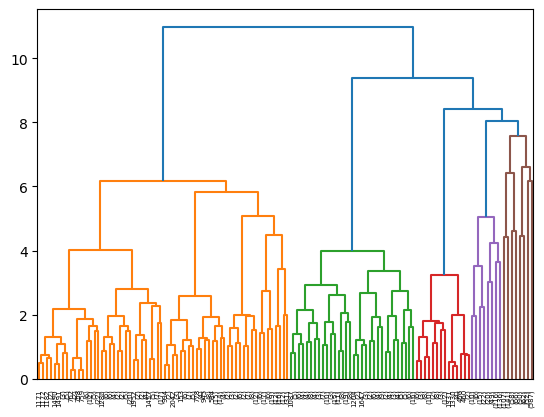

In [23]:
plot_dendrogram(linkage_clusters, truncate_mode = "level", p = 6)

In [61]:
clusters = list(range(2, cluster_index_2.columns[2:].size + 2))
score = np.zeros(len(clusters))

In [62]:
for i, labels in enumerate(cluster_index_2.columns[2:]): 
    score[i] = silhouette_score(X, cluster_index_2.loc[:, labels].to_list(), metric="euclidean")
silhouette["method_2"] = pd.DataFrame(
    {
    "cluster" : clusters, 
    "score" : score
    }
)

In [63]:
for i, labels in enumerate(cluster_index_2.columns[2:]): 
    score[i] = calinski_harabasz_score(X, cluster_index_2.loc[:, labels].to_list())
calinski_harabasz["method_2"] = pd.DataFrame(
    {
    "cluster" : clusters, 
    "score" : score
    }
)

In [64]:
for i, labels in enumerate(cluster_index_2.columns[2:]): 
    score[i] = davies_bouldin_score(X, cluster_index_2.loc[:, labels].to_list())
davies_bouldin["method_2"] = pd.DataFrame(
    {
    "cluster" : clusters, 
    "score" : score
    }
)

In [79]:
abund_hellinger = sites_taxa.apply(lambda x: np.sqrt(x / sum(x)), axis = 1).drop(columns="Unknown")
bc_dist = ssd.DistanceMatrix(squareform(pdist(abund_hellinger.values, metric = "euclidean")), list(range(sites_taxa.shape[0])))

In [80]:
Anosim = {}
statistic = np.zeros(19)
p_val = np.zeros(19)
for i, method in enumerate([f"ward_{n}" for n in range(2,21)]):
    anosim_res = ssd.anosim(bc_dist, cluster_index_2[method].to_list(), permutations=99)
    print(method, anosim_res["test statistic"], anosim_res["p-value"])
    statistic[i] = anosim_res["test statistic"]
    p_val[i] = anosim_res["p-value"]
Anosim["method_2"] = pd.DataFrame(
    {
    "cluster" : list(range(2,21)), 
    "statistic" : statistic,
    "p-value" : p_val
    })

ward_2 0.2540090032911663 0.01
ward_3 0.340357554610867 0.01
ward_4 0.38500174274095805 0.01
ward_5 0.27958809032812015 0.01
ward_6 0.28922854420748445 0.01
ward_7 0.2909389745084249 0.01
ward_8 0.29853884934039043 0.01
ward_9 0.3235428106243897 0.01
ward_10 0.35693453246012646 0.01
ward_11 0.37268635063972244 0.01
ward_12 0.4172541276843234 0.01
ward_13 0.4441606840107264 0.01
ward_14 0.45722141161388435 0.01
ward_15 0.4771867106359337 0.01
ward_16 0.4797832792677195 0.01
ward_17 0.5050725142225609 0.01
ward_18 0.5126797053538118 0.01
ward_19 0.5153180830686322 0.01
ward_20 0.5247279337877937 0.01


## plots and scores

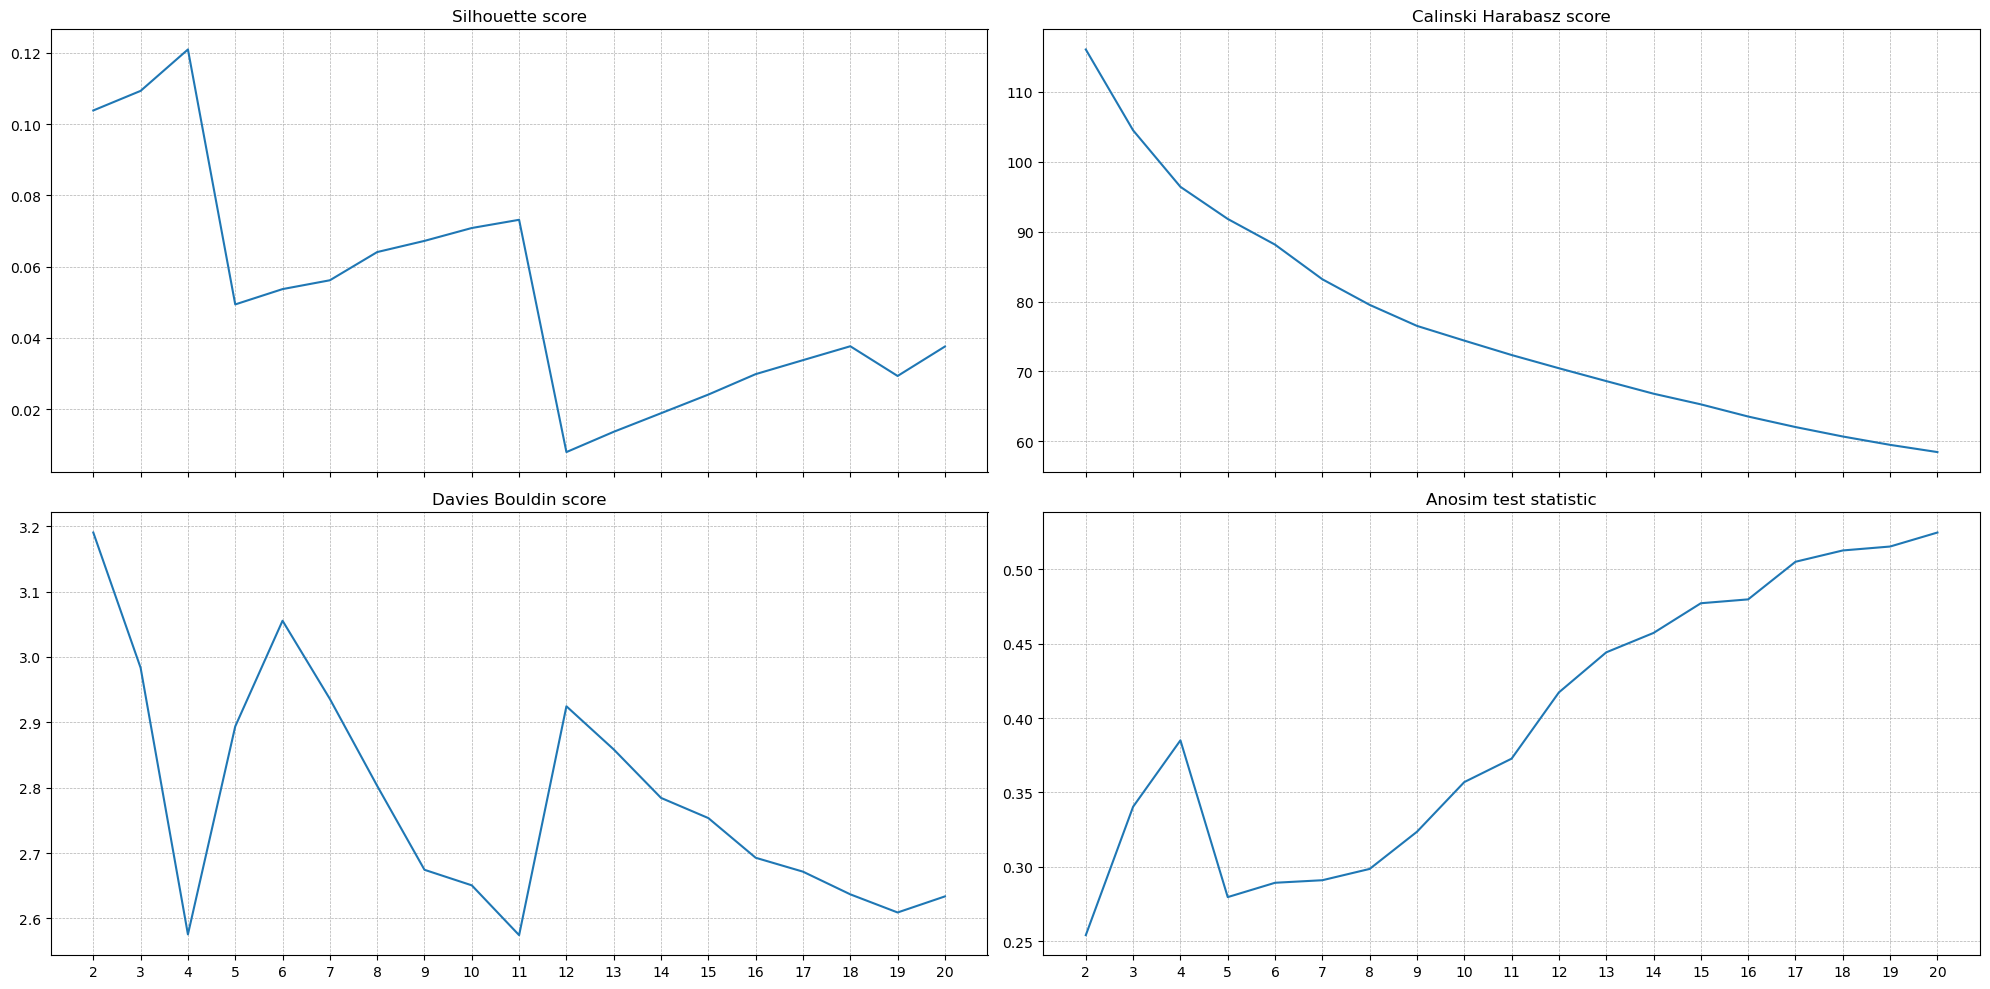

In [150]:
fig, axs = plt.subplots(2, 2, figsize = (20, 10), sharex=True)
axs = axs.flatten()
axs[0].plot(silhouette["method_2"]["cluster"], silhouette["method_2"]["score"])
axs[0].set_title("Silhouette score")
axs[1].plot(calinski_harabasz["method_2"]["cluster"], calinski_harabasz["method_2"]["score"])
axs[1].set_title("Calinski Harabasz score")
axs[2].plot(davies_bouldin["method_2"]["cluster"], davies_bouldin["method_2"]["score"])
axs[2].set_title("Davies Bouldin score")
axs[3].plot(Anosim["method_2"]["cluster"], Anosim["method_2"]["statistic"])
axs[3].set_title("Anosim test statistic")

for ax in axs: 
    ax.grid(visible = True, which="major", axis = "both", linestyle="--", linewidth=0.5)
    ax.set_xticks(range(2, 21))
plt.tight_layout()
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Clustering/Unknown_effect/Clustering_scores_method_2.png", bbox_inches = "tight")

In [94]:
IndVal = pd.read_excel(_HOME_ + "/ISPRA_20152017_Analysis/Clustering/Unknown_effect/IndVal_method_2.xlsx", sheet_name = None, index_col=0)

In [97]:
IndVal = pd.concat(IndVal, keys = IndVal.keys(), names = ["N_clusters", "Taxon"]).reset_index()
IndVal["N_clusters"] = IndVal["N_clusters"].apply(lambda x: int(x.split("_")[-1]))

In [114]:
IndVal.query("stat >= 0.5").groupby("N_clusters").nunique().reset_index().apply(lambda x: x["index"] / x["N_clusters"], axis = 1)

0     1.000000
1     1.000000
2     1.000000
3     0.800000
4     0.833333
5     0.857143
6     0.750000
7     0.777778
8     0.700000
9     0.636364
10    0.583333
11    0.615385
12    0.642857
13    0.666667
14    0.625000
15    0.647059
16    0.666667
17    0.684211
18    0.700000
dtype: float64

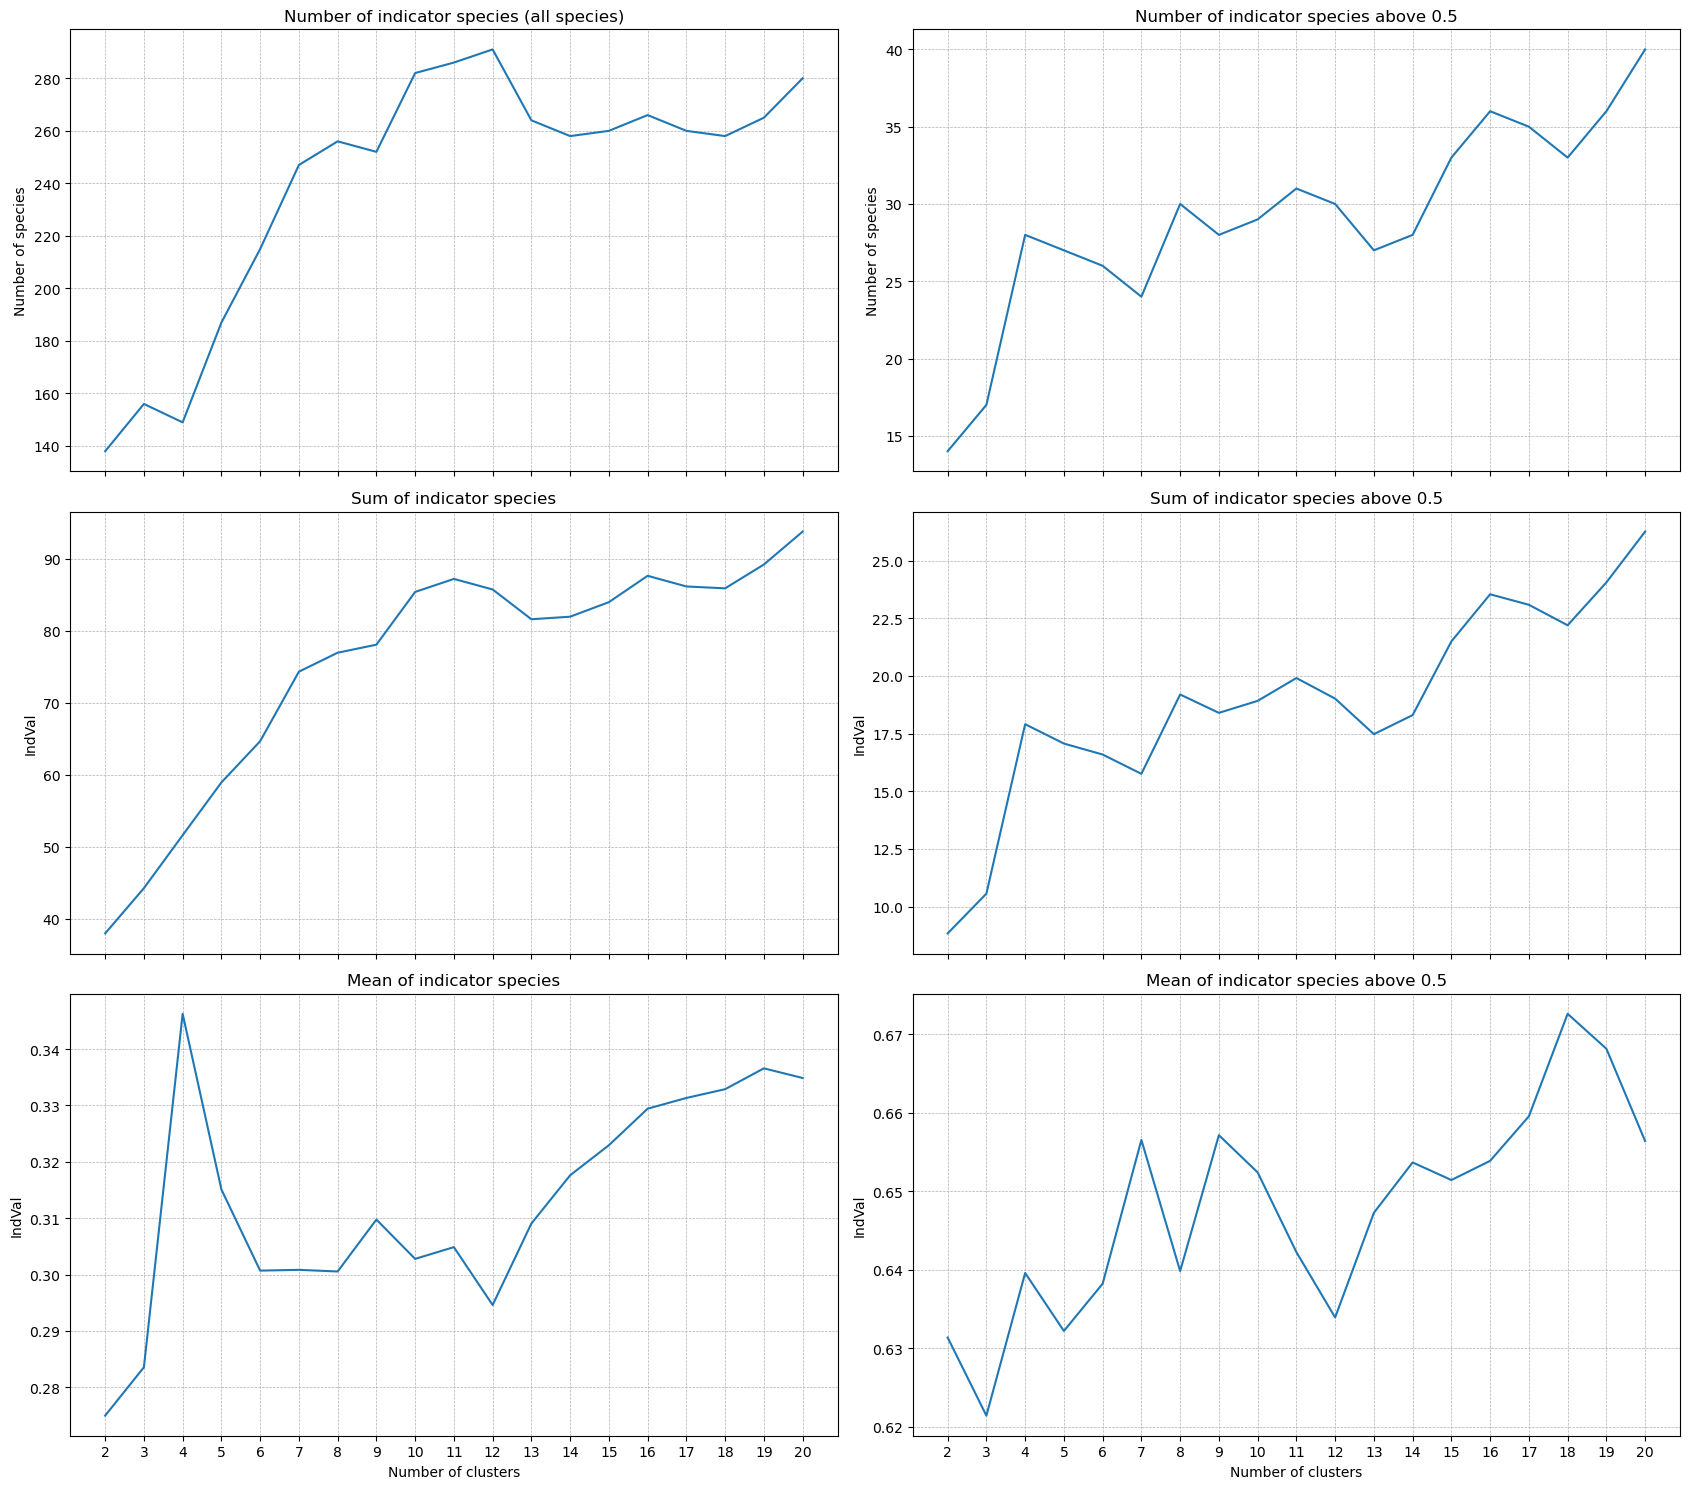

In [152]:
fig, axs = plt.subplots(3,2, figsize = (17, 15), sharex=True)

df = IndVal.groupby("N_clusters").agg({"Taxon" : "count", "stat" : ["sum", "mean"]}).reset_index()
statistic = [("Taxon", "count"), ("stat", "sum"), ("stat", "mean")]
titles = np.array([["Number of indicator species (all species)", "Number of indicator species above 0.5"], 
                   ["Sum of indicator species", "Sum of indicator species above 0.5"], 
                   ["Mean of indicator species", "Mean of indicator species above 0.5"]]
                   )
y_lables = ["Number of species", "IndVal", "IndVal"] 

for i, ax in enumerate(axs[:,0]): 
    sns.lineplot(
        data = df,
        x = "N_clusters",
        y =  statistic[i], 
        ax = ax
    )
    ax.set_xlabel("Number of clusters")
    ax.set_ylabel(y_lables[i])
    


df = IndVal.query("stat > 0.5").groupby("N_clusters").agg({"Taxon" : "count", "stat" : ["sum", "mean"]}).reset_index()
for i, ax in enumerate(axs[:,1]): 
    sns.lineplot(
        data = df,
        x = "N_clusters",
        y =  statistic[i], 
        ax = ax
    )
    ax.set_xlabel("Number of clusters")
    ax.set_ylabel(y_lables[i])

np.vectorize(lambda ax, title: ax.set_title(title))(axs, titles)

for ax in axs.flatten():
    ax.grid(visible = True, which="major", axis = "both", linestyle="--", linewidth=0.5)
    ax.set_xticks(range(2,21))
plt.tight_layout()
plt.savefig(_HOME_ + "/ISPRA_20152017_Analysis/Clustering/Unknown_effect/IndVal_scores_method_2.png", bbox_inches = "tight")

In [154]:
abund_method_2 = phyto_abund_simplified.merge(cluster_index_2, on = ["Date", "id"])
abund_method_2["Month"] = abund_method_2["Date"].dt.month_name()
abund_method_2["Month"] = pd.Categorical(abund_method_2["Month"], categories = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered = True)
abund_method_2["Region"] = pd.Categorical(abund_method_2["Region"], categories = ordered_regions, ordered = True)
abund_method_2["Season"] = pd.Categorical(abund_method_2["Season"], categories = list(seasons.keys()), ordered = True)
abund_method_2["id"] = pd.Categorical(abund_method_2["id"], categories = ordered_id, ordered = True)
abund_method_2 = add_mid_year_column(abund_method_2)

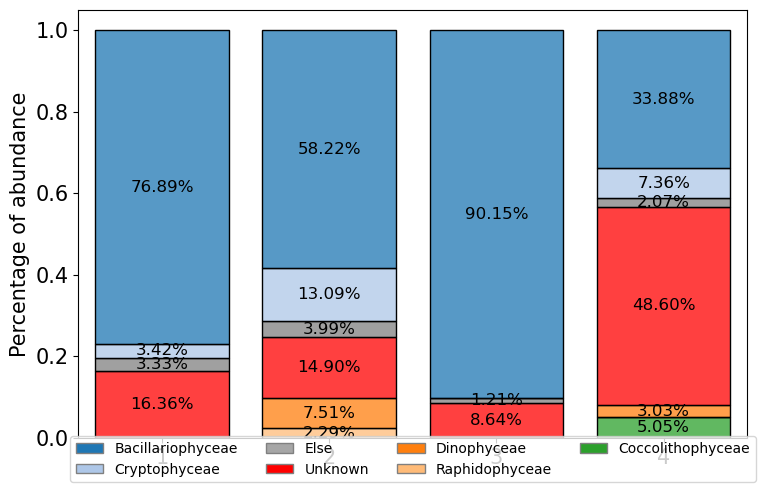

In [176]:
fig, ax = plt.subplots(1, 1, figsize = (8, 5))
plot_cat_contribution_to_cluster(abund_method_2, category = "Class", unknown = True, method = "ward_4", ax = ax);
plt.tight_layout()

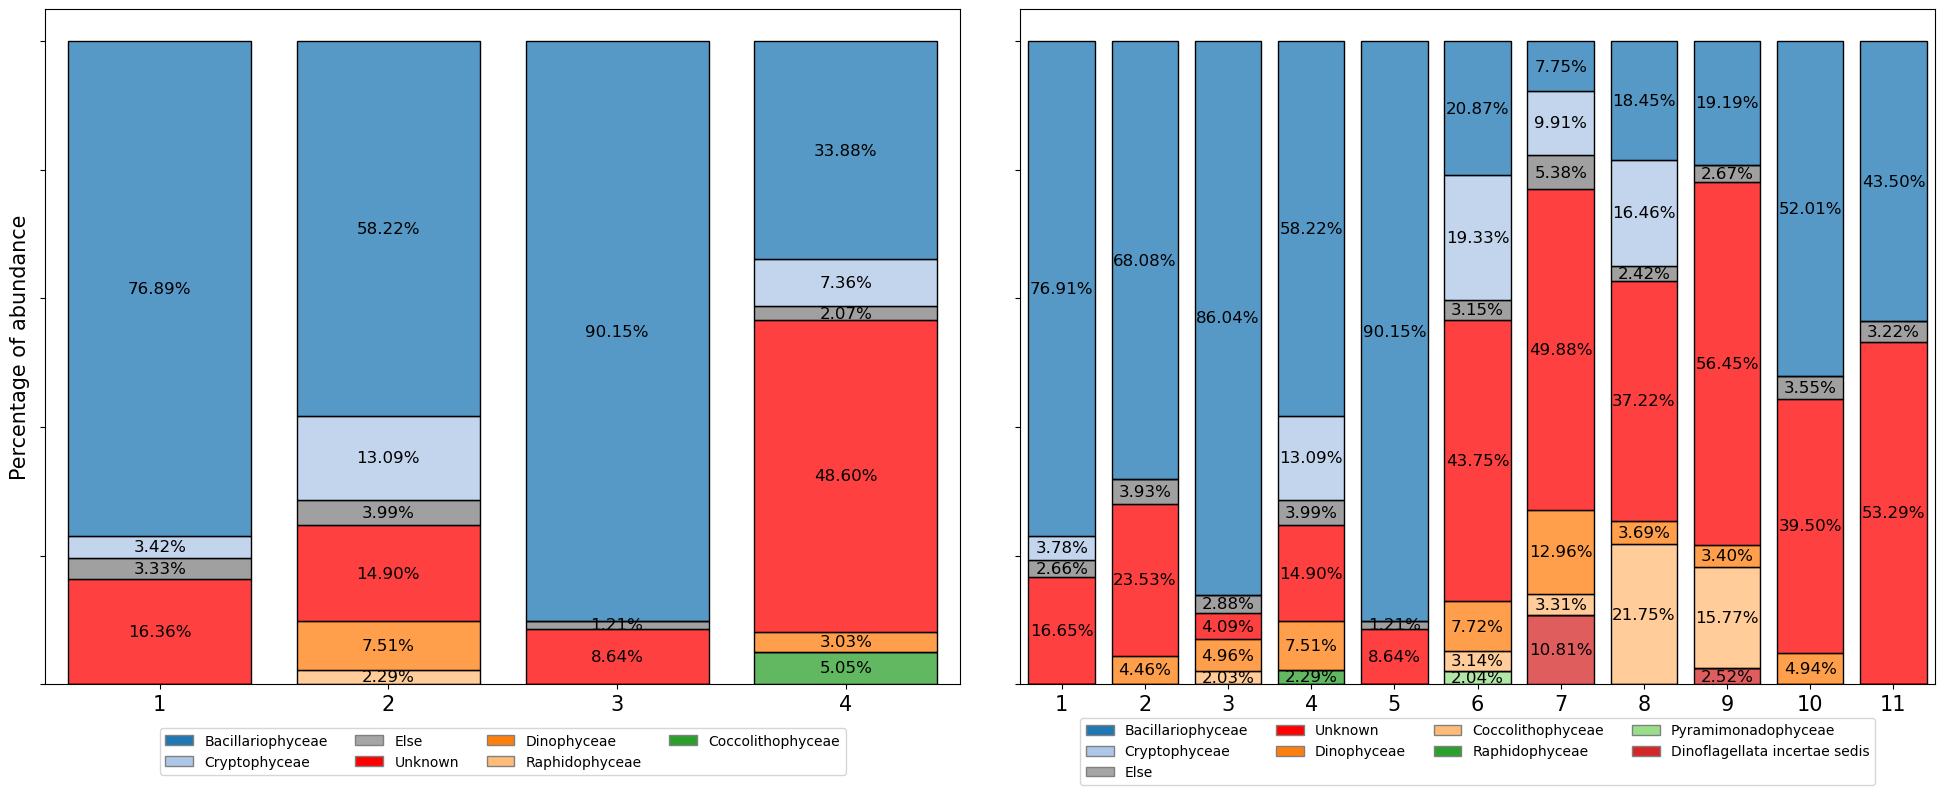

In [189]:
fig, axs = plt.subplots(1, 2, figsize = (20, 8), sharey=True)
plot_cat_contribution_to_cluster(abund_method_2, category = "Class", unknown = True, method = "ward_4", ax = axs[0], bbox_to_anchor=(0, -0.15, 1, 0.101));
plot_cat_contribution_to_cluster(abund_method_2, category = "Class", unknown = True, method = "ward_11", ax = axs[1], bbox_to_anchor=(0, -0.15, 1, 0.101));
plt.tight_layout()

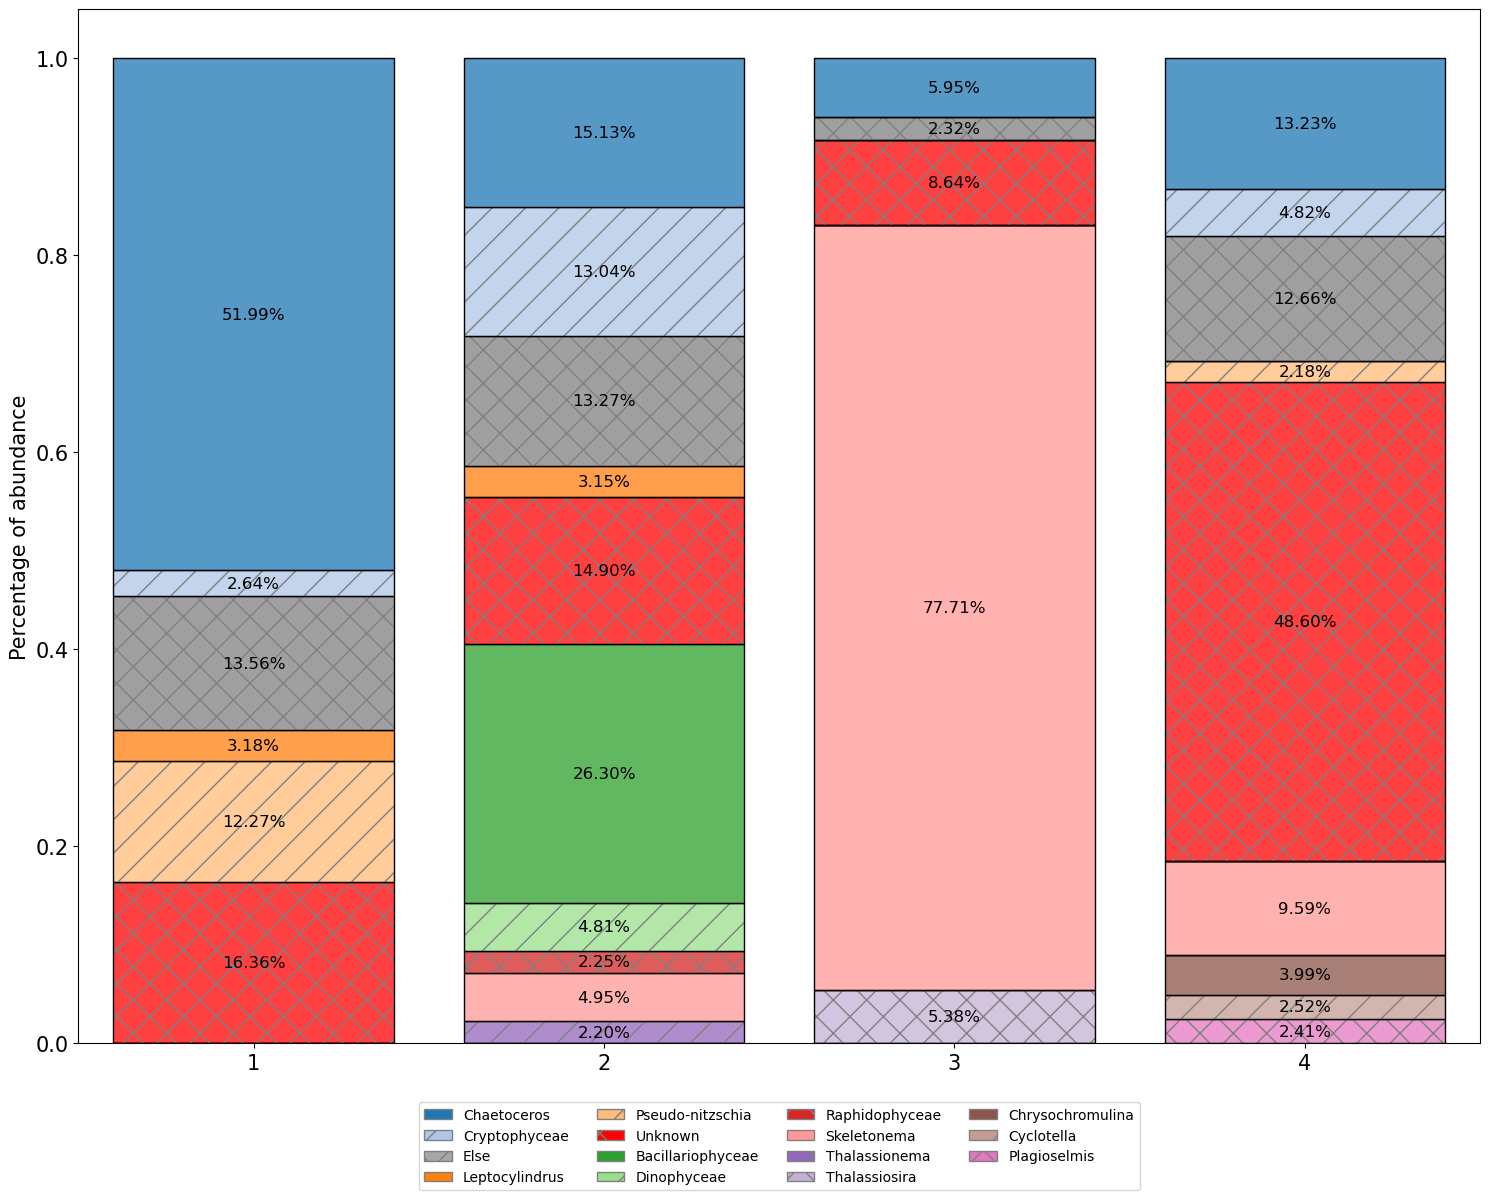

In [192]:
plot_cat_contribution_to_cluster(abund_method_2, category = "Genus", unknown = True, method = "ward_4", bbox_to_anchor=(0, -0.15, 1, 0.101))

# Method 3: Unknown also in cluster

In [199]:
abund_hellinger = sites_taxa.apply(lambda x: np.sqrt(x / sum(x)), axis = 1)
X = abund_hellinger.values

cluster_index_3 = {}
single_linkage_clustering = AgglomerativeClustering(n_clusters = None, metric = "euclidean", linkage = "ward", compute_distances = True, compute_full_tree=True, distance_threshold=0.0)
linkage_clusters = single_linkage_clustering.fit(X)
linkage_matrix = build_linkage_matrix(linkage_clusters)
for n in range(2,21):
    cluster_index_3[f"ward_{n}"] = fcluster(linkage_matrix, t = n, criterion = "maxclust")

cluster_index_3 = pd.DataFrame(cluster_index_3)
cluster_index_3.index = sites_taxa.index
cluster_index_3.reset_index(inplace=True)
cluster_index_3["Date"] = pd.to_datetime(cluster_index_3["Date"])
cluster_index_3["id"] = pd.Categorical(cluster_index_3["id"], categories = ordered_id, ordered = True)

In [200]:
clusters = list(range(2, cluster_index_3.columns[2:].size + 2))
score = np.zeros(len(clusters))

In [201]:
for i, labels in enumerate(cluster_index_3.columns[2:]): 
    score[i] = silhouette_score(X, cluster_index_3.loc[:, labels].to_list(), metric="euclidean")
silhouette["method_3"] = pd.DataFrame(
    {
    "cluster" : clusters, 
    "score" : score
    }
)

In [202]:
for i, labels in enumerate(cluster_index_3.columns[2:]): 
    score[i] = calinski_harabasz_score(X, cluster_index_3.loc[:, labels].to_list())
calinski_harabasz["method_3"] = pd.DataFrame(
    {
    "cluster" : clusters, 
    "score" : score
    }
)

In [203]:
for i, labels in enumerate(cluster_index_3.columns[2:]): 
    score[i] = davies_bouldin_score(X, cluster_index_3.loc[:, labels].to_list())
davies_bouldin["method_3"] = pd.DataFrame(
    {
    "cluster" : clusters, 
    "score" : score
    }
)

# Method 4: remove samples with high unknown

In [54]:
sample_abund = phyto_abund_simplified.groupby(["Date", "id"], observed=True).sum(numeric_only=True)
relevant_samples = phyto_abund_simplified.query("Taxon == 'Unknown'")[["Date", "id", "Num_cell_l"]].set_index(["Date", "id"]).div(sample_abund[["Num_cell_l"]]).query("Num_cell_l <= 0.3").index
taxon_slice = phyto_abund_simplified.set_index(["Date", "id"]).loc[relevant_samples, :].groupby("Taxon").count().query("Num_cell_l > 5").index

In [205]:
abund_hellinger = sites_taxa.loc[relevant_samples, taxon_slice].drop(columns="Unknown").apply(lambda x: np.sqrt(x / sum(x)), axis = 1)
X = abund_hellinger.values

In [206]:
cluster_index_4 = {}
single_linkage_clustering = AgglomerativeClustering(n_clusters = None, metric = "euclidean", linkage = "ward", compute_distances = True, compute_full_tree=True, distance_threshold=0.0)
linkage_clusters = single_linkage_clustering.fit(X)
linkage_matrix = build_linkage_matrix(linkage_clusters)
for n in range(2,21):
    cluster_index_4[f"ward_{n}"] = fcluster(linkage_matrix, t = n, criterion = "maxclust")

cluster_index_4 = pd.DataFrame(cluster_index_4)
cluster_index_4.index = relevant_samples
cluster_index_4.reset_index(inplace=True)
cluster_index_4["Date"] = pd.to_datetime(cluster_index_4["Date"])
cluster_index_4["id"] = pd.Categorical(cluster_index_4["id"], categories = ordered_id, ordered = True)

In [207]:
clusters = list(range(2, cluster_index_4.columns[2:].size + 2))
score = np.zeros(len(clusters))

In [208]:
for i, labels in enumerate(cluster_index_4.columns[2:]): 
    score[i] = silhouette_score(X, cluster_index_4.loc[:, labels].to_list(), metric="euclidean")
silhouette["method_4"] = pd.DataFrame(
    {
    "cluster" : clusters, 
    "score" : score
    }
)

In [209]:
for i, labels in enumerate(cluster_index_4.columns[2:]): 
    score[i] = calinski_harabasz_score(X, cluster_index_4.loc[:, labels].to_list())
calinski_harabasz["method_4"] = pd.DataFrame(
    {
    "cluster" : clusters, 
    "score" : score
    }
)

In [210]:
for i, labels in enumerate(cluster_index_4.columns[2:]): 
    score[i] = davies_bouldin_score(X, cluster_index_4.loc[:, labels].to_list())
davies_bouldin["method_4"] = pd.DataFrame(
    {
    "cluster" : clusters, 
    "score" : score
    }
)

# exporting cluster indices

In [173]:
with pd.ExcelWriter(_HOME_ + "/ISPRA_20152017_Analysis/Clustering/Unknown_effect/cluster_indices.xlsx") as writer:
    cluster_index_1.to_excel(writer, sheet_name="method_1", index = False)
    cluster_index_2.to_excel(writer, sheet_name="method_2", index = False)
    cluster_index_3.to_excel(writer, sheet_name="method_3", index = False)
    cluster_index_4.to_excel(writer, sheet_name="method_4", index = False)

In [19]:
cluster_index_1 = pd.read_excel(_HOME_ + "/ISPRA_20152017_Analysis/Clustering/Unknown_effect/cluster_indices.xlsx", sheet_name="method_1")
cluster_index_2 = pd.read_excel(_HOME_ + "/ISPRA_20152017_Analysis/Clustering/Unknown_effect/cluster_indices.xlsx", sheet_name="method_2")
cluster_index_3 = pd.read_excel(_HOME_ + "/ISPRA_20152017_Analysis/Clustering/Unknown_effect/cluster_indices.xlsx", sheet_name="method_3")
cluster_index_4 = pd.read_excel(_HOME_ + "/ISPRA_20152017_Analysis/Clustering/Unknown_effect/cluster_indices.xlsx", sheet_name="method_4")

# Cluster consensus

In [211]:
cluster_methods = {}
cluster_methods["1"] = cluster_index_1.set_index(["Date", "id"])
cluster_methods["2"] = cluster_index_2.set_index(["Date", "id"])
cluster_methods["3"] = cluster_index_3.set_index(["Date", "id"])
cluster_methods["4"] = cluster_index_4.set_index(["Date", "id"])

In [43]:
df_consensus = pd.DataFrame(
        {},
        columns = pd.MultiIndex(levels = [[], []], codes = [[], []], names = ["Index", "Methods"])
    )
for method_1, method_2 in combinations(cluster_methods.keys(), 2): 
    labels_1 = cluster_methods[method_1]
    labels_2 = cluster_methods[method_2]
    scores_1 = np.zeros(labels_1.shape[1])
    scores_2 = np.zeros(labels_2.shape[1])
    for i in range(labels_1.shape[1]): 
        scores_1[i] = metrics.adjusted_rand_score(labels_1.iloc[:,i].values, labels_2.iloc[:,i].values)
        scores_2[i] = metrics.normalized_mutual_info_score(labels_1.iloc[:,i].values, labels_2.iloc[:,i].values)
        df_consensus[("ARI", f"{method_1}_{method_2}")] = scores_1
        df_consensus[("NMI", f"{method_1}_{method_2}")] = scores_2
    df_consensus = df_consensus.loc[:, ["ARI", "NMI"]]
df_consensus.index = labels_1.columns

<Axes: xlabel='Index-Methods'>

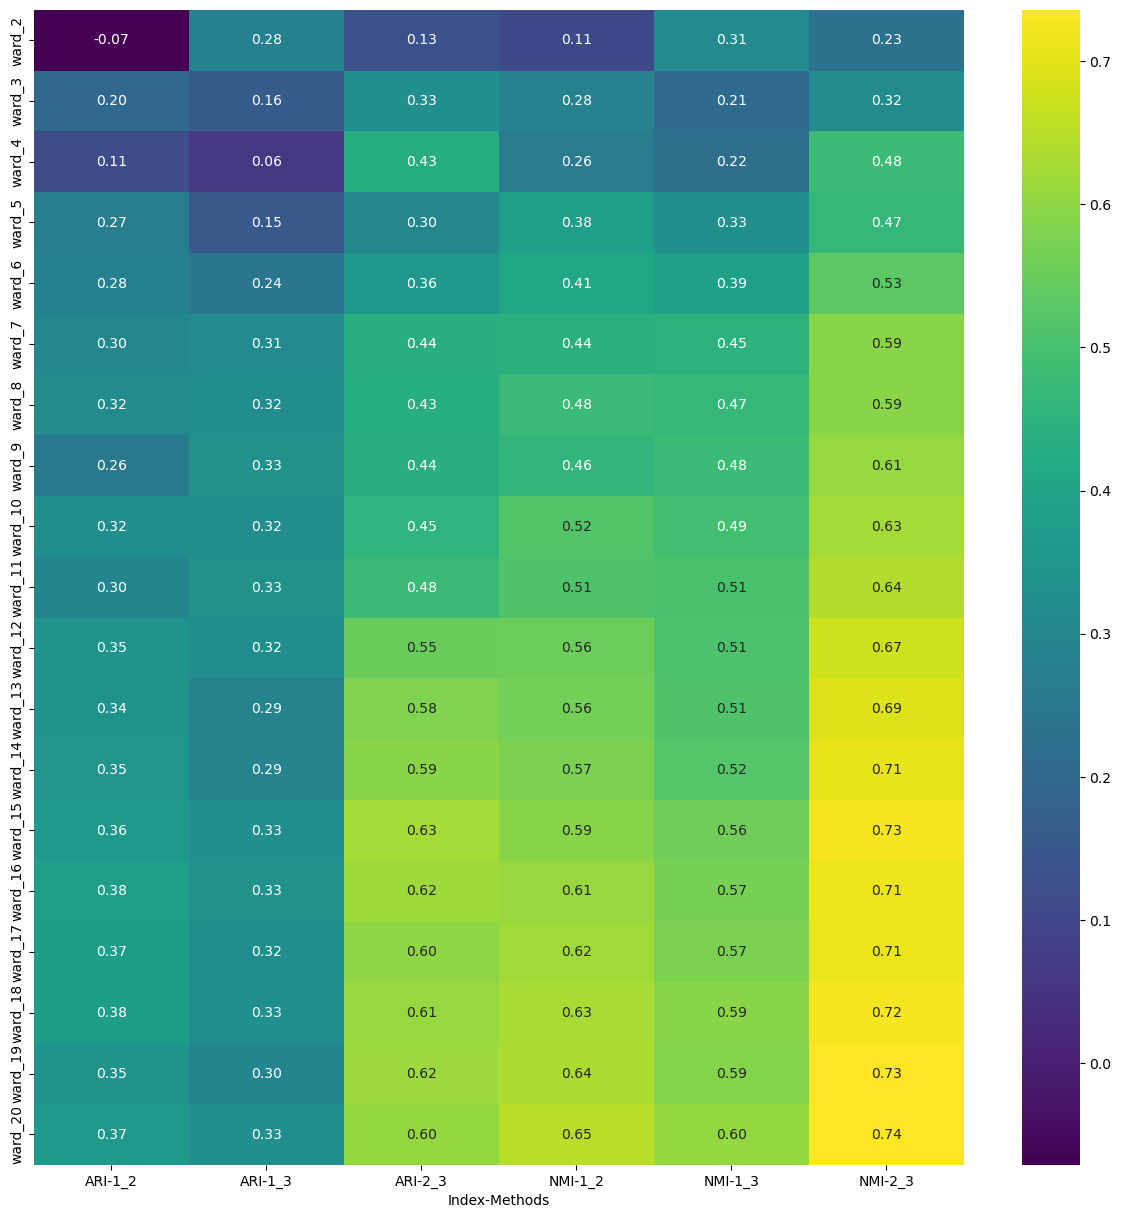

In [45]:
fig, ax = plt.subplots(1, 1, figsize = (15, 15))
sns.heatmap(df_consensus, ax = ax, cmap = plt.get_cmap("viridis"), annot = True, fmt = ".2f")

<Axes: xlabel='cluster', ylabel='score'>

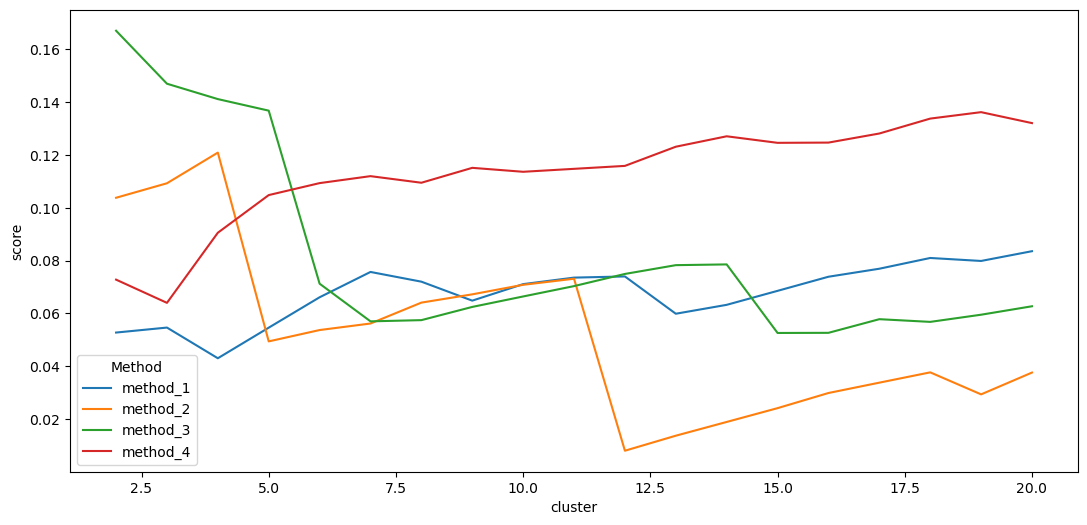

In [212]:
fig, ax = plt.subplots(1, 1, figsize = (13, 6))
sns.lineplot(
    pd.concat(silhouette.values(), keys = silhouette.keys(), names = ["Method"]).reset_index(),
    x = "cluster",
    y = "score",
    hue = "Method",
    )

<Axes: xlabel='cluster', ylabel='score'>

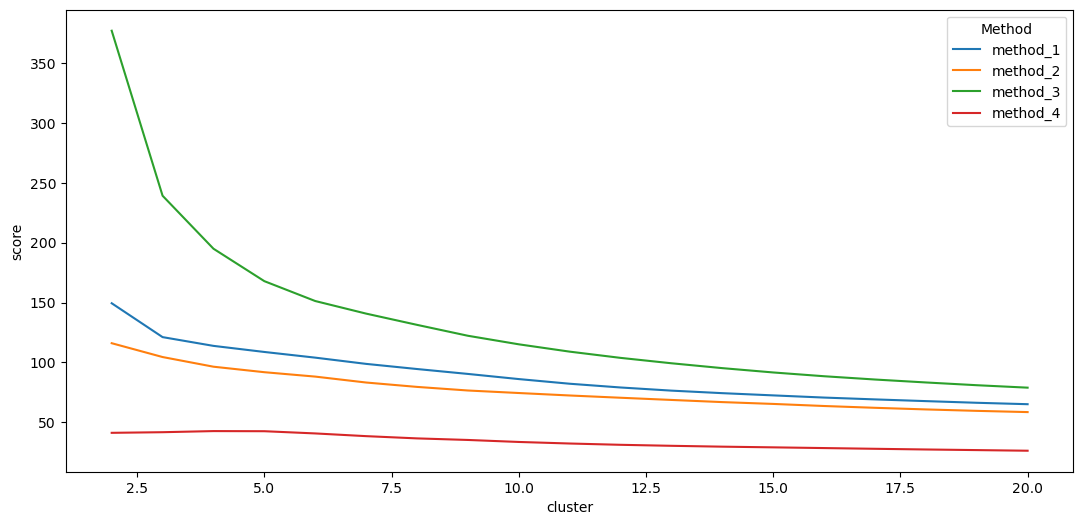

In [213]:
fig, ax = plt.subplots(1, 1, figsize = (13, 6))
sns.lineplot(
    pd.concat(calinski_harabasz.values(), keys = calinski_harabasz.keys(), names = ["Method"]).reset_index(),
    x = "cluster",
    y = "score",
    hue = "Method",
    )

<Axes: xlabel='cluster', ylabel='score'>

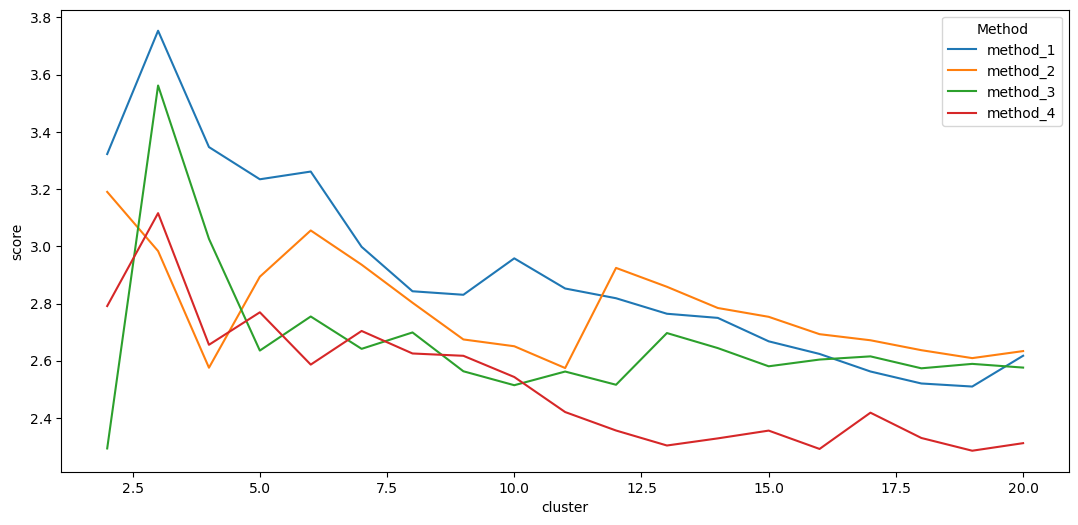

In [214]:
fig, ax = plt.subplots(1, 1, figsize = (13, 6))
sns.lineplot(
    pd.concat(davies_bouldin.values(), keys = davies_bouldin.keys(), names = ["Method"]).reset_index(),
    x = "cluster",
    y = "score",
    hue = "Method",
    )

# Anosim

In [22]:
Anosim = {}

## Method 1

In [18]:
abund_hellinger = sites_taxa.drop(columns="Unknown").apply(lambda x: np.sqrt(x / sum(x)), axis = 1)
bc_dist = ssd.DistanceMatrix(squareform(pdist(abund_hellinger.values, metric = "euclidean")), list(range(sites_taxa.shape[0])))

In [30]:
statistic = np.zeros(19)
p_val = np.zeros(19)
for i, method in enumerate([f"ward_{n}" for n in range(2,21)]):
    anosim_res = ssd.anosim(bc_dist, cluster_index_1[method].to_list(), permutations=99)
    print(method, anosim_res["test statistic"], anosim_res["p-value"])
    statistic[i] = anosim_res["test statistic"]
    p_val[i] = anosim_res["p-value"]
Anosim["method_1"] = pd.DataFrame(
    {
    "cluster" : list(range(2,21)), 
    "statistic" : statistic,
    "p-value" : p_val
    }
)

ward_2 0.06568602901103635 0.01
ward_3 0.1475279048451998 0.01
ward_4 0.073493587220093 0.01
ward_5 0.219374870431282 0.01
ward_6 0.3476506243889618 0.01
ward_7 0.40044579202660274 0.01
ward_8 0.3766009956783013 0.01
ward_9 0.3453748126616512 0.01
ward_10 0.47760539187071244 0.01
ward_11 0.47903063610096036 0.01
ward_12 0.4815637322720726 0.01
ward_13 0.4472296519512789 0.01
ward_14 0.4814268636049493 0.01
ward_15 0.495770651728528 0.01
ward_16 0.5381417827918238 0.01
ward_17 0.5426501284892639 0.01
ward_18 0.5413656131765594 0.01
ward_19 0.5088519952431362 0.01
ward_20 0.6607241083568159 0.01


## Method 2

In [73]:
abund_hellinger = sites_taxa.apply(lambda x: np.sqrt(x / sum(x)), axis = 1).drop(columns="Unknown")
bc_dist = ssd.DistanceMatrix(squareform(pdist(abund_hellinger.values, metric = "euclidean")), list(range(sites_taxa.shape[0])))

In [33]:
statistic = np.zeros(19)
p_val = np.zeros(19)
for i, method in enumerate([f"ward_{n}" for n in range(2,21)]):
    anosim_res = ssd.anosim(bc_dist, cluster_index_2[method].to_list(), permutations=99)
    print(method, anosim_res["test statistic"], anosim_res["p-value"])
    statistic[i] = anosim_res["test statistic"]
    p_val[i] = anosim_res["p-value"]
Anosim["method_2"] = pd.DataFrame(
    {
    "cluster" : list(range(2,21)), 
    "statistic" : statistic,
    "p-value" : p_val
    })

ward_2 0.2540090032911663 0.01
ward_3 0.340357554610867 0.01
ward_4 0.38500174274095805 0.01
ward_5 0.27958809032812015 0.01
ward_6 0.28922854420748445 0.01
ward_7 0.2909389745084249 0.01
ward_8 0.29853884934039043 0.01
ward_9 0.3235428106243897 0.01
ward_10 0.35693453246012646 0.01
ward_11 0.37268635063972244 0.01
ward_12 0.4172541276843234 0.01
ward_13 0.4441606840107264 0.01
ward_14 0.45722141161388435 0.01
ward_15 0.4771867106359337 0.01
ward_16 0.4797832792677195 0.01
ward_17 0.5050725142225609 0.01
ward_18 0.5126797053538118 0.01
ward_19 0.5153180830686322 0.01
ward_20 0.5247279337877937 0.01


## Method 3

In [50]:
abund_hellinger = sites_taxa.apply(lambda x: np.sqrt(x / sum(x)), axis = 1)
bc_dist = ssd.DistanceMatrix(squareform(pdist(abund_hellinger.values, metric = "euclidean")), list(range(sites_taxa.shape[0])))

In [34]:
statistic = np.zeros(19)
p_val = np.zeros(19)
for i, method in enumerate([f"ward_{n}" for n in range(2,21)]):
    anosim_res = ssd.anosim(bc_dist, cluster_index_3[method].to_list(), permutations=99)
    print(method, anosim_res["test statistic"], anosim_res["p-value"])
    statistic[i] = anosim_res["test statistic"]
    p_val[i] = anosim_res["p-value"]
Anosim["method_3"] = pd.DataFrame(
    {
    "cluster" : list(range(2,21)), 
    "statistic" : statistic,
    "p-value" : p_val
    })

ward_2 0.13271284091995986 0.01
ward_3 0.41792370496491527 0.01
ward_4 0.4751519602788983 0.01
ward_5 0.4901731038234375 0.01
ward_6 0.3086658684614547 0.01
ward_7 0.12982302881111366 0.01
ward_8 0.24211417442113797 0.01
ward_9 0.23125131267761778 0.01
ward_10 0.28937987672075405 0.01
ward_11 0.36638878819124243 0.01
ward_12 0.40632099647286385 0.01
ward_13 0.525244994692544 0.01
ward_14 0.5476045841995751 0.01
ward_15 0.49070593419074243 0.01
ward_16 0.5042002146545856 0.01
ward_17 0.5039363179734292 0.01
ward_18 0.5115415680206601 0.01
ward_19 0.5837976948558501 0.01
ward_20 0.5969229622812727 0.01


In [175]:
abund_hellinger = sites_taxa.loc[relevant_samples, taxon_slice].drop(columns="Unknown").apply(lambda x: np.sqrt(x / sum(x)), axis = 1)
bc_dist = ssd.DistanceMatrix(squareform(pdist(abund_hellinger.values, metric = "euclidean")), list(range(relevant_samples.size)))

In [176]:
statistic = np.zeros(19)
p_val = np.zeros(19)
for i, method in enumerate([f"ward_{n}" for n in range(2,21)]):
    anosim_res = ssd.anosim(bc_dist, cluster_index_4[method].to_list(), permutations=99)
    print(method, anosim_res["test statistic"], anosim_res["p-value"])
    statistic[i] = anosim_res["test statistic"]
    p_val[i] = anosim_res["p-value"]
Anosim["method_4"] = pd.DataFrame(
    {
    "cluster" : list(range(2,21)), 
    "statistic" : statistic,
    "p-value" : p_val
    })

ward_2 0.3179620204165013 0.01
ward_3 0.18848543145756022 0.01
ward_4 0.29007010408832373 0.01
ward_5 0.43976791869229986 0.01
ward_6 0.44772205536925813 0.01
ward_7 0.5700110888712627 0.01
ward_8 0.5525476750120111 0.01
ward_9 0.6043738807194118 0.01
ward_10 0.6027842282816337 0.01
ward_11 0.6048935640243177 0.01
ward_12 0.5948335616095457 0.01
ward_13 0.6698565209669936 0.01
ward_14 0.677838478777754 0.01
ward_15 0.6963451684989165 0.01
ward_16 0.6954779767650279 0.01
ward_17 0.7393833195752789 0.01
ward_18 0.7443899757276988 0.01
ward_19 0.7471546878684603 0.01
ward_20 0.7235521110342755 0.01


<Axes: xlabel='cluster', ylabel='statistic'>

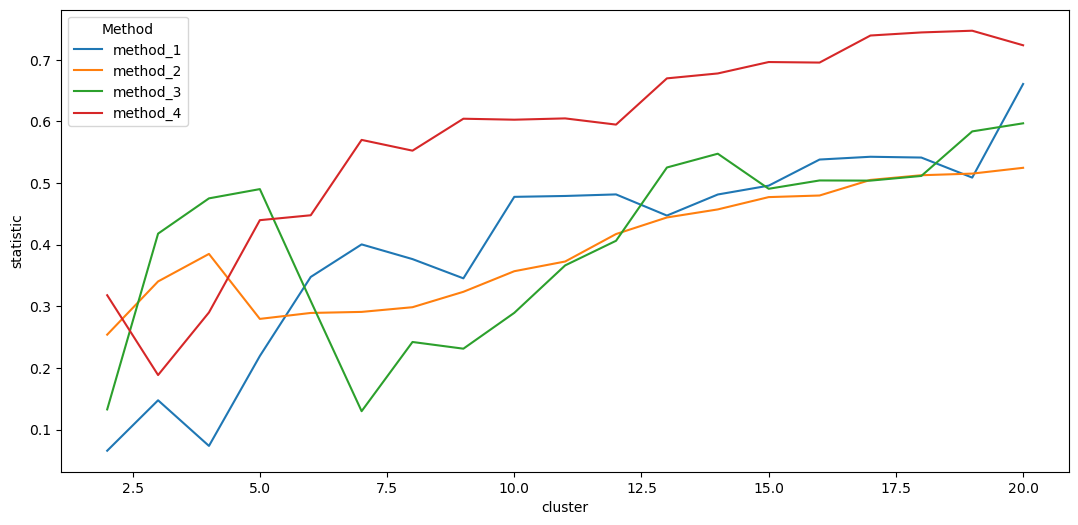

In [177]:
fig, ax = plt.subplots(1, 1, figsize = (13, 6))
sns.lineplot(
    pd.concat(Anosim.values(), keys = Anosim.keys(), names = ["Method"]).reset_index(),
    x = "cluster",
    y = "statistic",
    hue = "Method",
    )

# visualization

In [20]:
abund_method_1 = phyto_abund_simplified.merge(cluster_index_1, on = ["Date", "id"])
abund_method_1["Month"] = abund_method_1["Date"].dt.month_name()
abund_method_1["Month"] = pd.Categorical(abund_method_1["Month"], categories = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered = True)
abund_method_1["Region"] = pd.Categorical(abund_method_1["Region"], categories = ordered_regions, ordered = True)
abund_method_1["Season"] = pd.Categorical(abund_method_1["Season"], categories = list(seasons.keys()), ordered = True)
abund_method_1["id"] = pd.Categorical(abund_method_1["id"], categories = ordered_id, ordered = True)

In [54]:
abund_method_2 = phyto_abund_simplified.merge(cluster_index_2, on = ["Date", "id"])
abund_method_2["Month"] = abund_method_2["Date"].dt.month_name()
abund_method_2["Month"] = pd.Categorical(abund_method_2["Month"], categories = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered = True)
abund_method_2["Region"] = pd.Categorical(abund_method_2["Region"], categories = ordered_regions, ordered = True)
abund_method_2["Season"] = pd.Categorical(abund_method_2["Season"], categories = list(seasons.keys()), ordered = True)
abund_method_2["id"] = pd.Categorical(abund_method_2["id"], categories = ordered_id, ordered = True)

In [22]:
abund_method_3 = phyto_abund_simplified.merge(cluster_index_3, on = ["Date", "id"])
abund_method_3["Month"] = abund_method_3["Date"].dt.month_name()
abund_method_3["Month"] = pd.Categorical(abund_method_3["Month"], categories = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered = True)
abund_method_3["Region"] = pd.Categorical(abund_method_3["Region"], categories = ordered_regions, ordered = True)
abund_method_3["Season"] = pd.Categorical(abund_method_3["Season"], categories = list(seasons.keys()), ordered = True)
abund_method_3["id"] = pd.Categorical(abund_method_3["id"], categories = ordered_id, ordered = True)

In [23]:
abund_method_4 = phyto_abund_simplified.merge(cluster_index_4, on = ["Date", "id"], how = "inner")
abund_method_4["Month"] = abund_method_4["Date"].dt.month_name()
abund_method_4["Month"] = pd.Categorical(abund_method_4["Month"], categories = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], ordered = True)
abund_method_4["Region"] = pd.Categorical(abund_method_4["Region"], categories = ordered_regions, ordered = True)
abund_method_4["Season"] = pd.Categorical(abund_method_4["Season"], categories = list(seasons.keys()), ordered = True)
abund_method_4["id"] = pd.Categorical(abund_method_4["id"], categories = ordered_id, ordered = True)

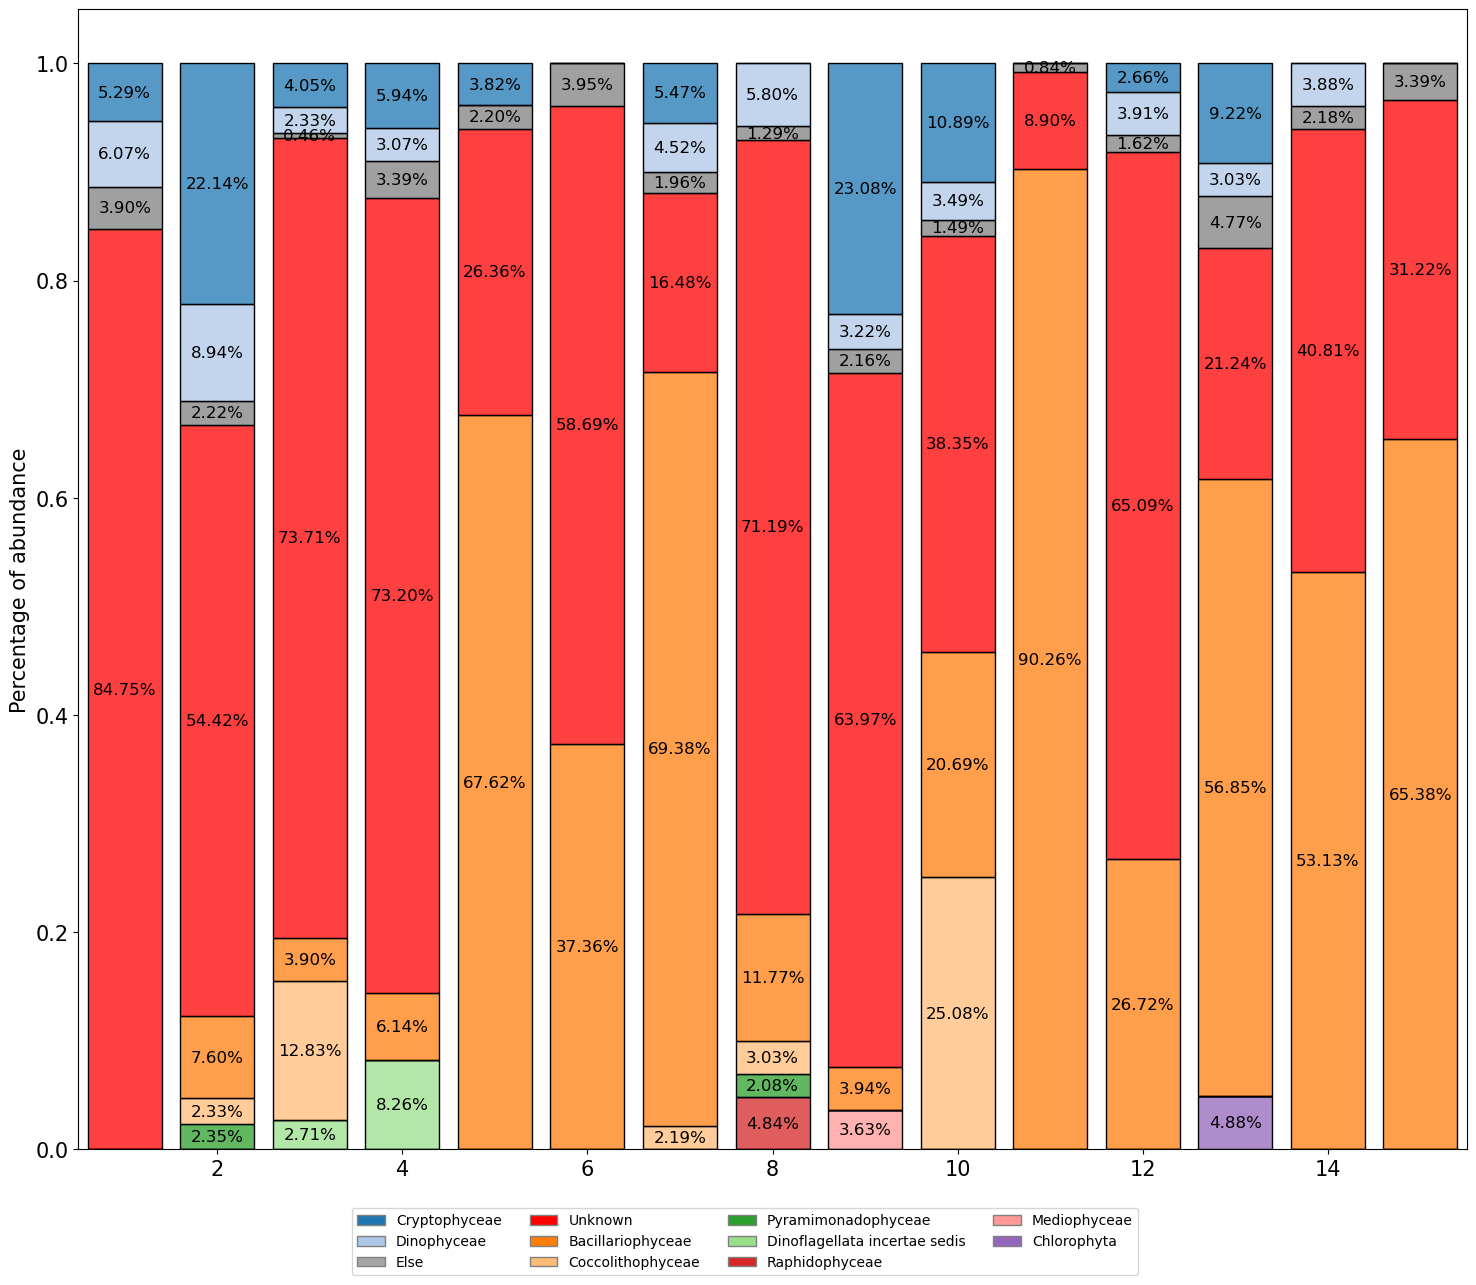

In [88]:
plot_cat_contribution_to_cluster(abund_method_1, category = "Class", unknown = True, method = "ward_15")

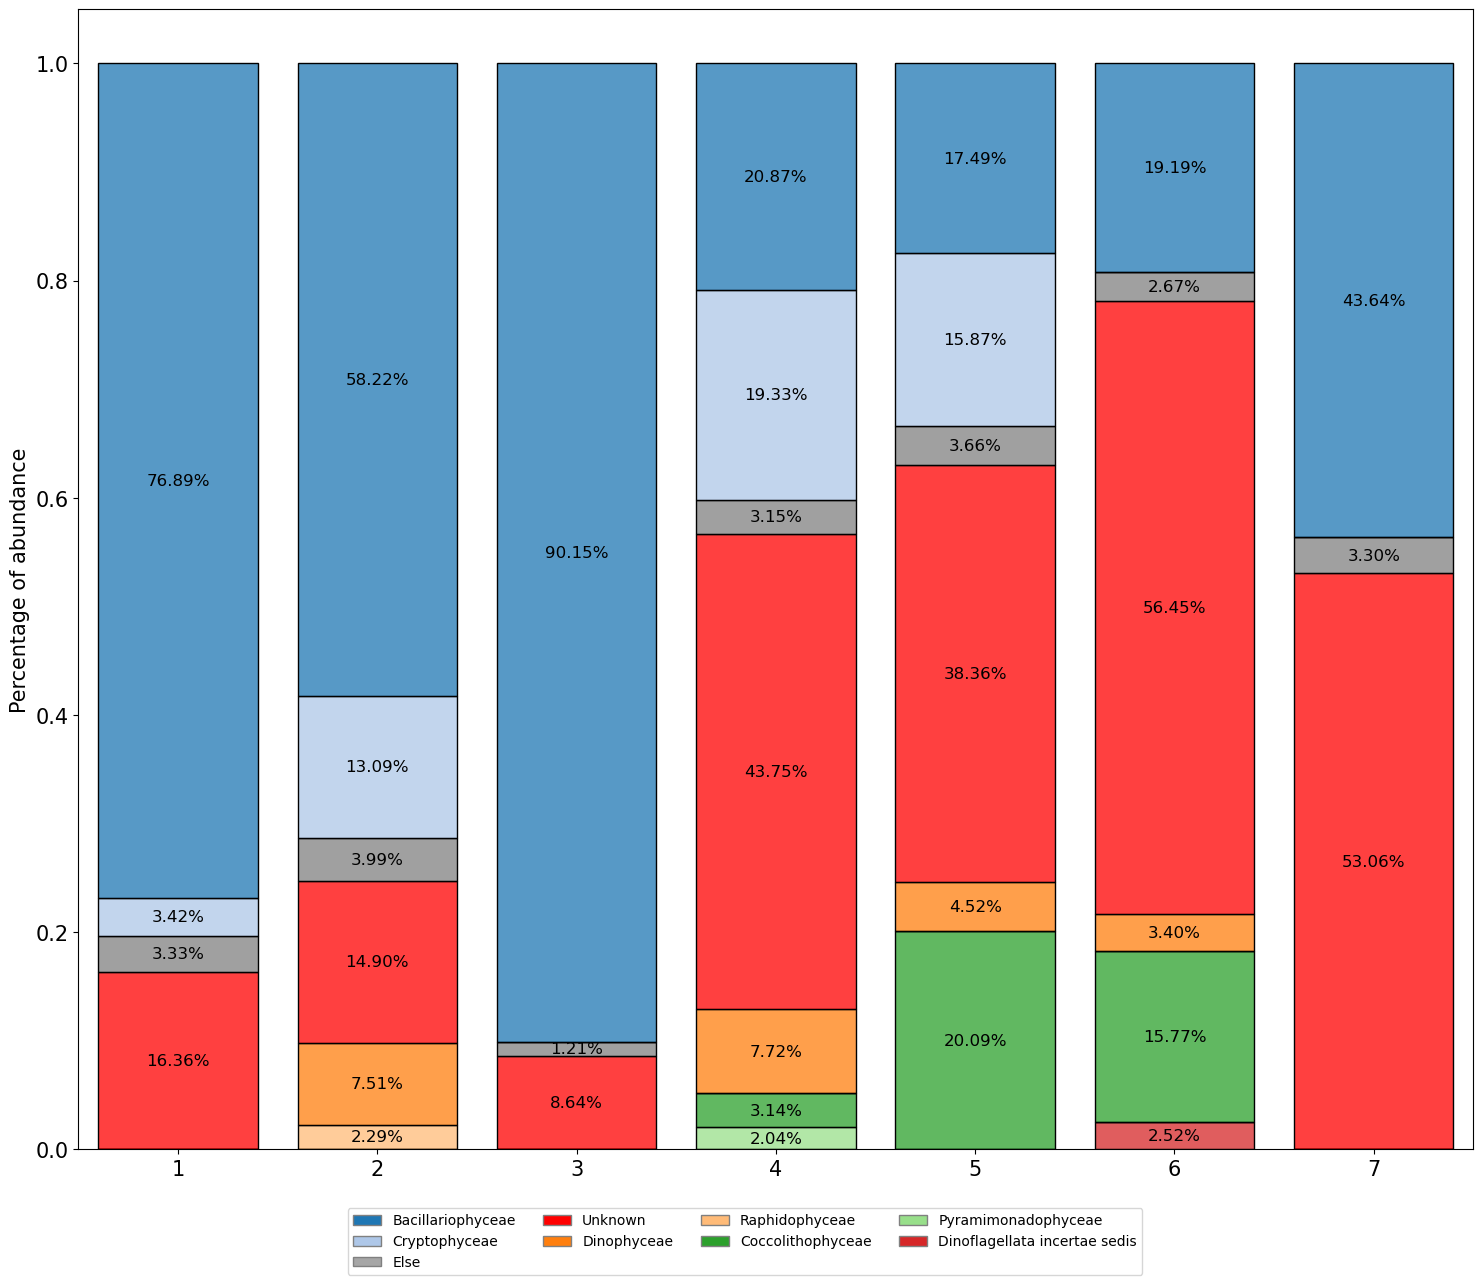

In [57]:
plot_cat_contribution_to_cluster(abund_method_2, category = "Class", unknown = True, method = "ward_7")

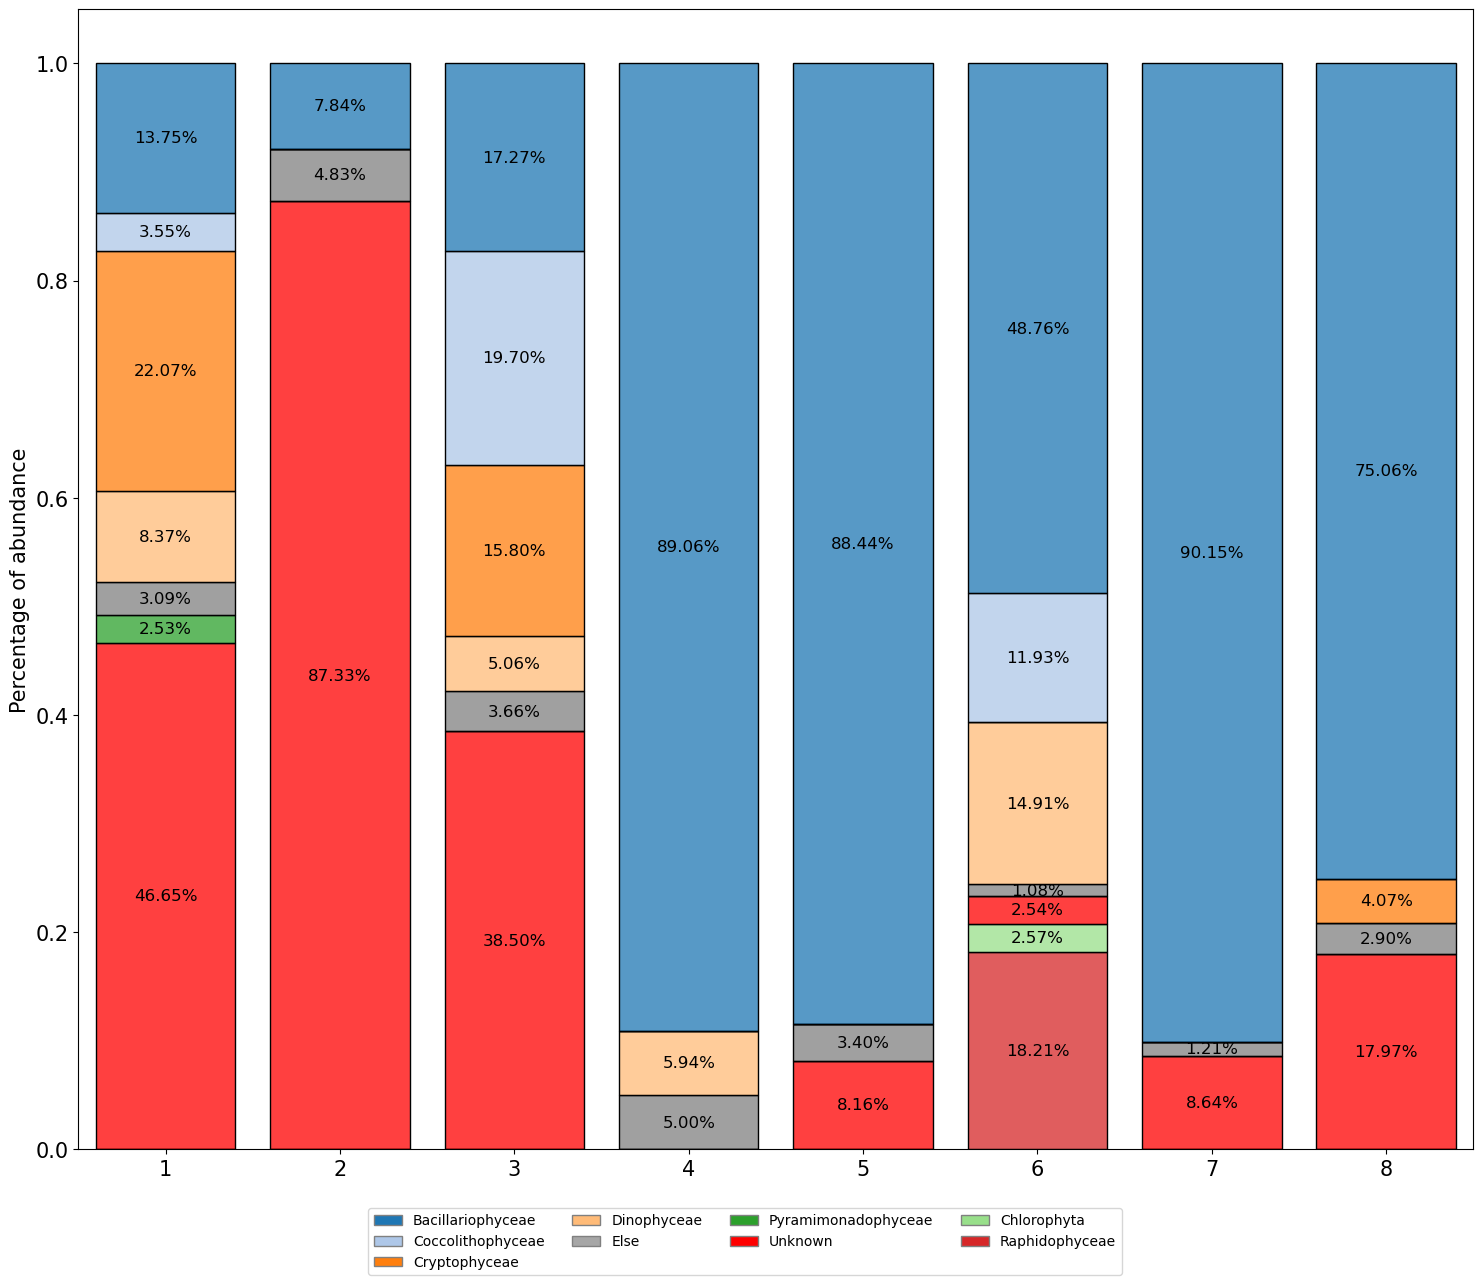

In [30]:
plot_cat_contribution_to_cluster(abund_method_3, category = "Class", unknown = True, method = "ward_8")

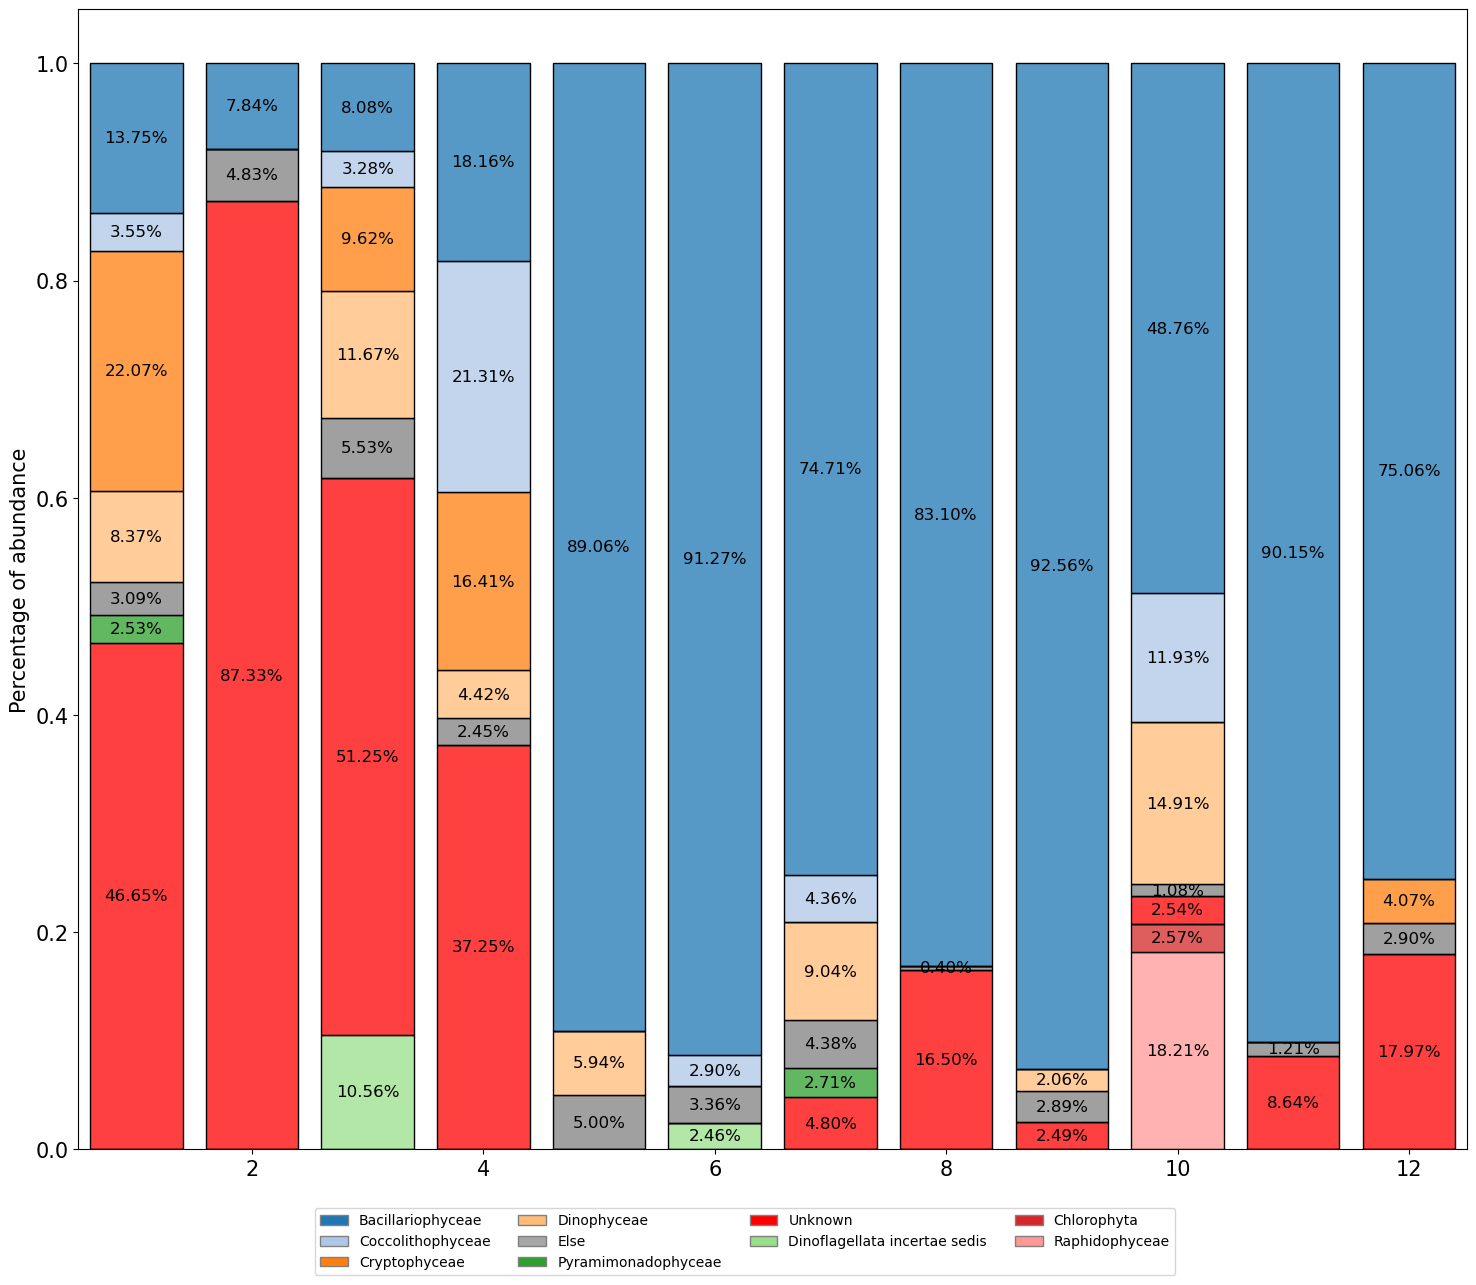

In [49]:
plot_cat_contribution_to_cluster(abund_method_3, category = "Class", unknown = True, method = "ward_12")

In [58]:
method = "ward_10"
sample_abund = abund_method_3.groupby([method, "Date", "id"], observed = True).sum(numeric_only=True)
abund_method_3.query("Taxon == 'Unknown'").set_index([method, "Date", "id"]).div(sample_abund).reset_index().groupby(method).agg({"Num_cell_l" : ["mean", "std"]})

Num_cell_l          
              mean       std
ward_10                     
1         0.461018  0.223594
2         0.813129  0.157737
3         0.500087  0.193430
4         0.366458  0.176318
5         0.025342  0.036847
6         0.115539  0.100830
7         0.095610  0.115015
8         0.126087  0.098999
9         0.149910  0.200502
10        0.297350  0.229342

In [59]:
method = "ward_8"
sample_abund = abund_method_3.groupby([method, "Date", "id"], observed = True).sum(numeric_only=True)
abund_method_3.query("Taxon == 'Unknown'").set_index([method, "Date", "id"]).div(sample_abund).reset_index().groupby(method).agg({"Num_cell_l" : ["mean", "std"]})

Num_cell_l          
             mean       std
ward_8                     
1        0.461018  0.223594
2        0.813129  0.157737
3        0.449870  0.197819
4        0.025342  0.036847
5        0.097650  0.113591
6        0.126087  0.098999
7        0.149910  0.200502
8        0.297350  0.229342

In [60]:
method = "ward_8"
sample_abund = abund_method_2.groupby([method, "Date", "id"], observed = True).sum(numeric_only=True)
abund_method_2.query("Taxon == 'Unknown'").set_index([method, "Date", "id"]).div(sample_abund).reset_index().groupby(method).agg({"Num_cell_l" : ["mean", "std"]})

Num_cell_l          
             mean       std
ward_8                     
1        0.235366  0.227254
2        0.206825  0.199549
3        0.149910  0.200502
4        0.440808  0.242190
5        0.475006  0.207937
6        0.358374  0.193874
7        0.444471  0.334024
8        0.692686  0.324001

In [61]:
method = "ward_10"
sample_abund = abund_method_2.groupby([method, "Date", "id"], observed = True).sum(numeric_only=True)
abund_method_2.query("Taxon == 'Unknown'").set_index([method, "Date", "id"]).div(sample_abund).reset_index().groupby(method).agg({"Num_cell_l" : ["mean", "std"]})

Num_cell_l          
              mean       std
ward_10                     
1         0.262593  0.224104
2         0.204989  0.227812
3         0.206825  0.199549
4         0.149910  0.200502
5         0.440808  0.242190
6         0.475006  0.207937
7         0.358374  0.193874
8         0.444471  0.334024
9         0.337644  0.300267
10        0.712595  0.313908

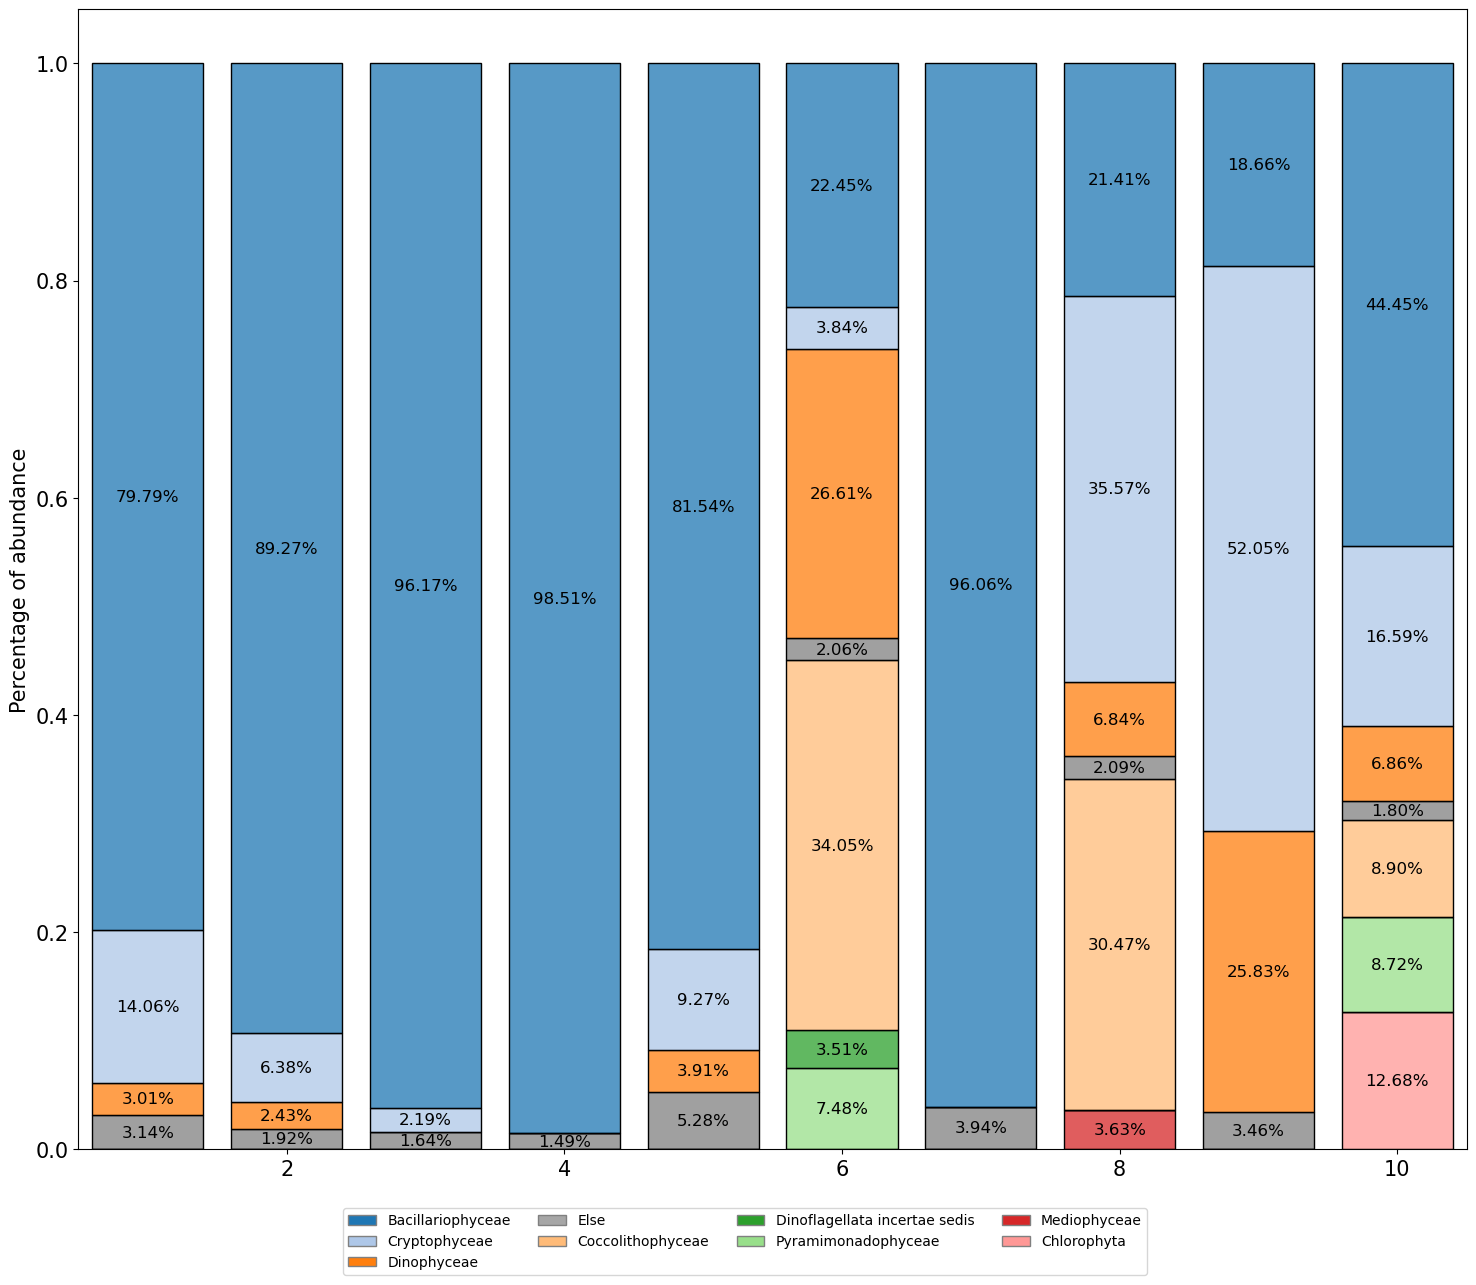

In [216]:
plot_cat_contribution_to_cluster(abund_method_4, category = "Class", unknown = False, method = "ward_10")

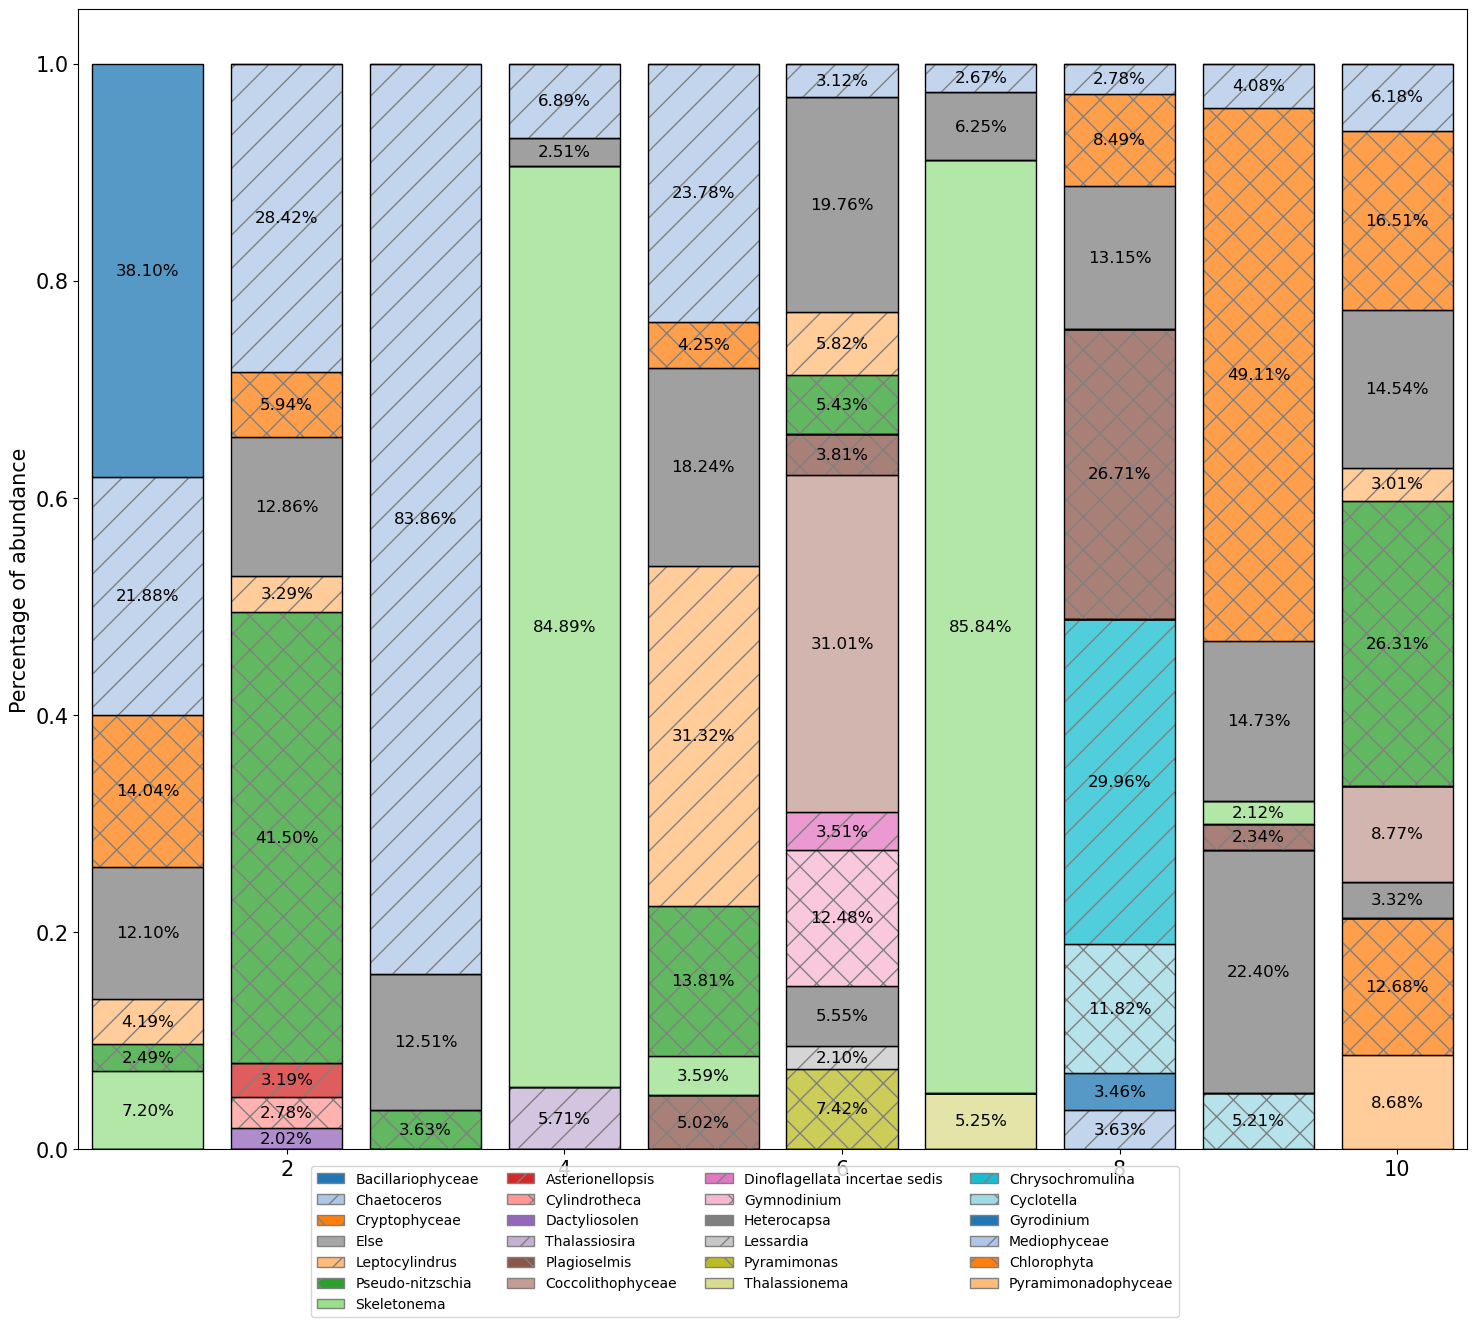

In [217]:
plot_cat_contribution_to_cluster(abund_method_4, category = "Genus", unknown = False, method = "ward_10")

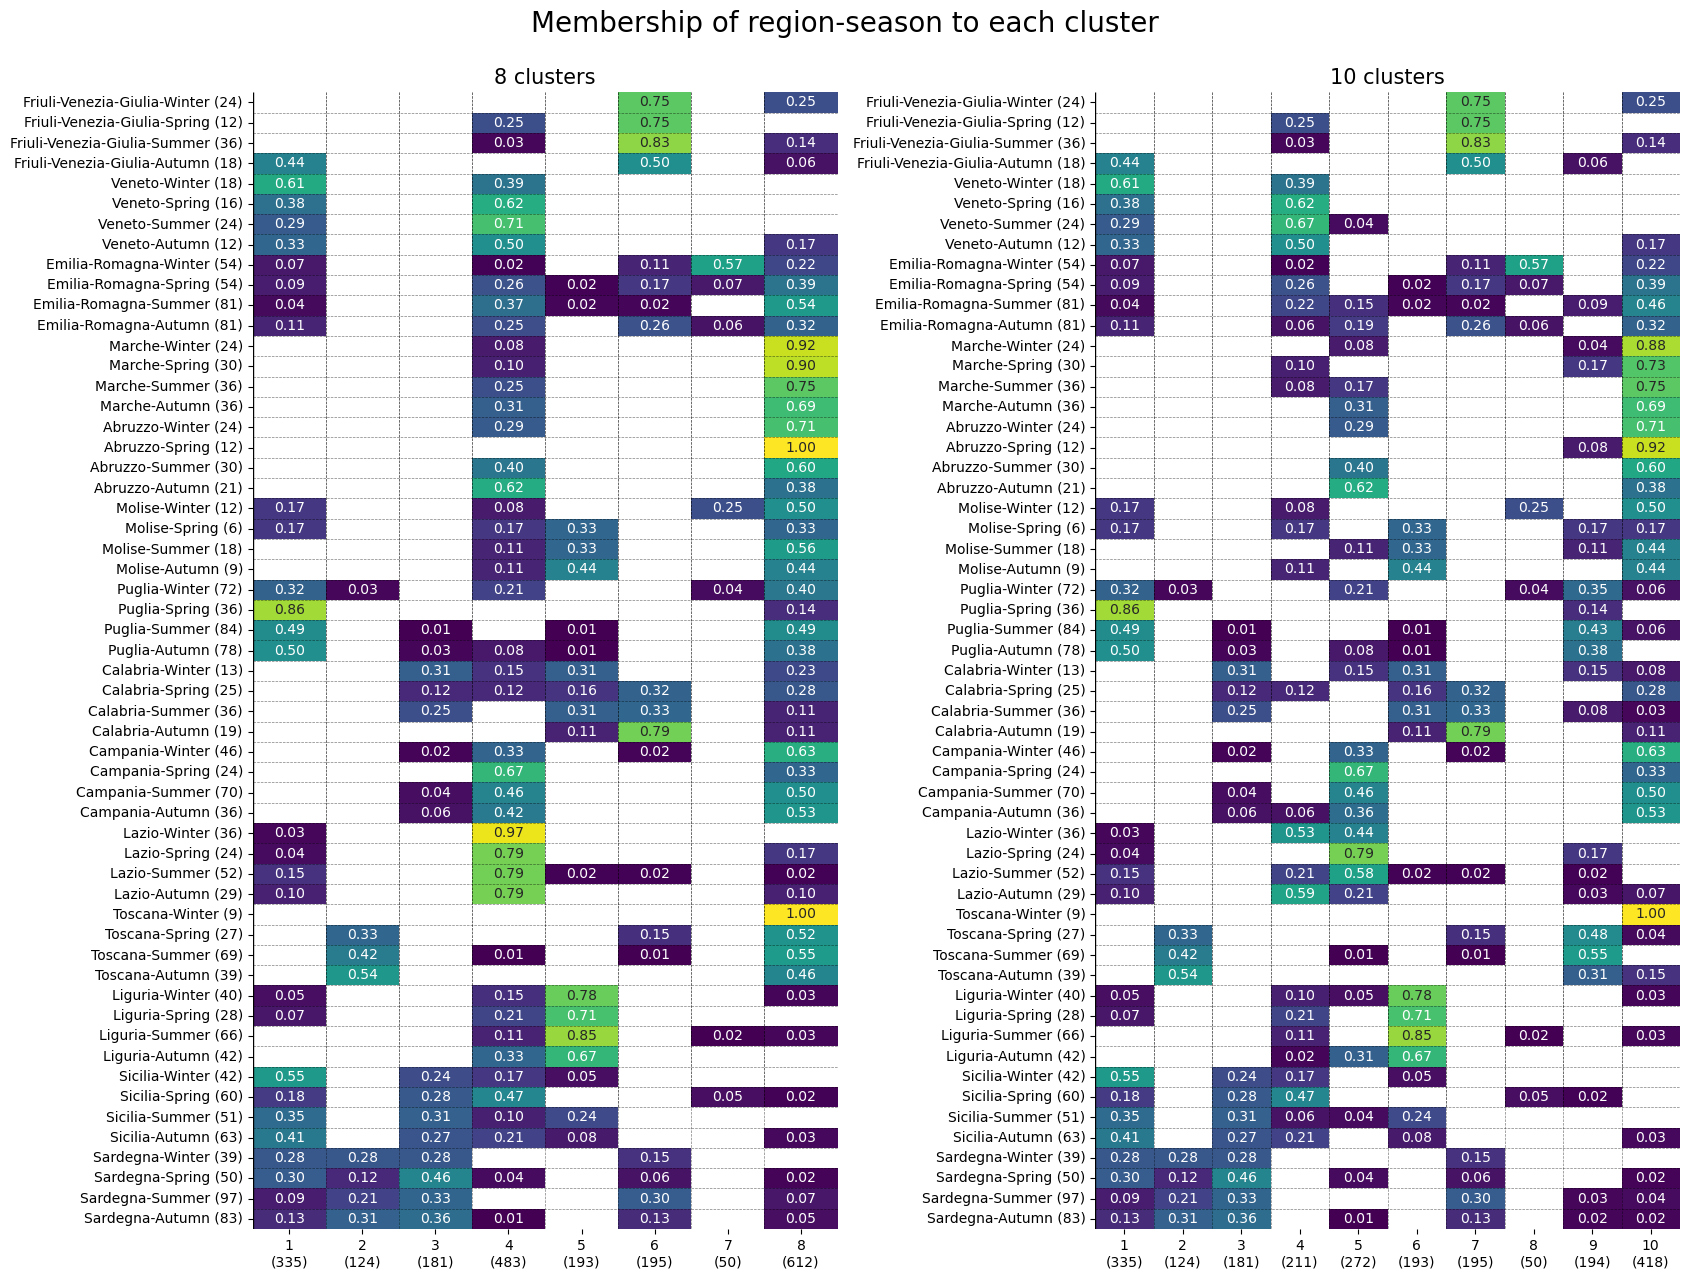

In [41]:
plot_region_season_membership(abund_method_1, methods = ["ward_8", "ward_10"])

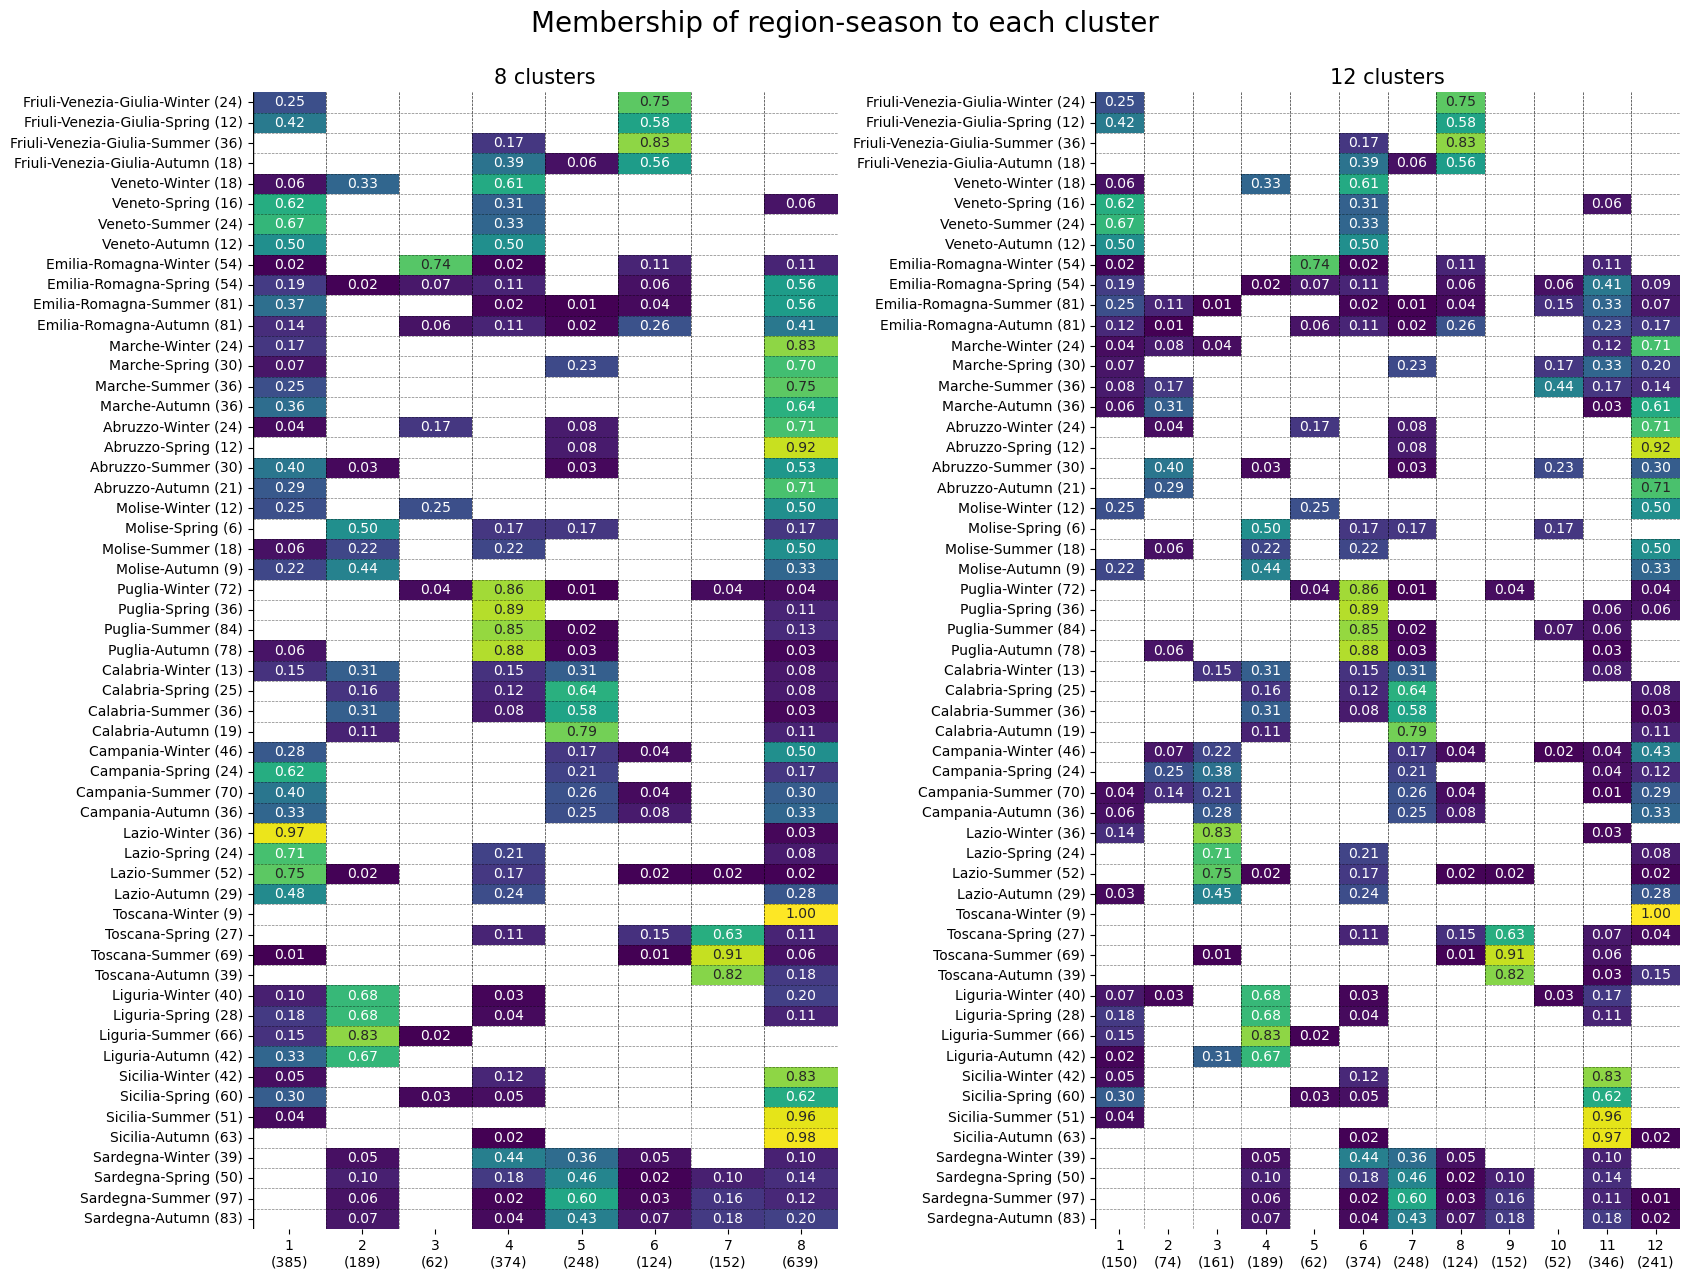

In [50]:
plot_region_season_membership(abund_method_2, methods = ["ward_8", "ward_10"])

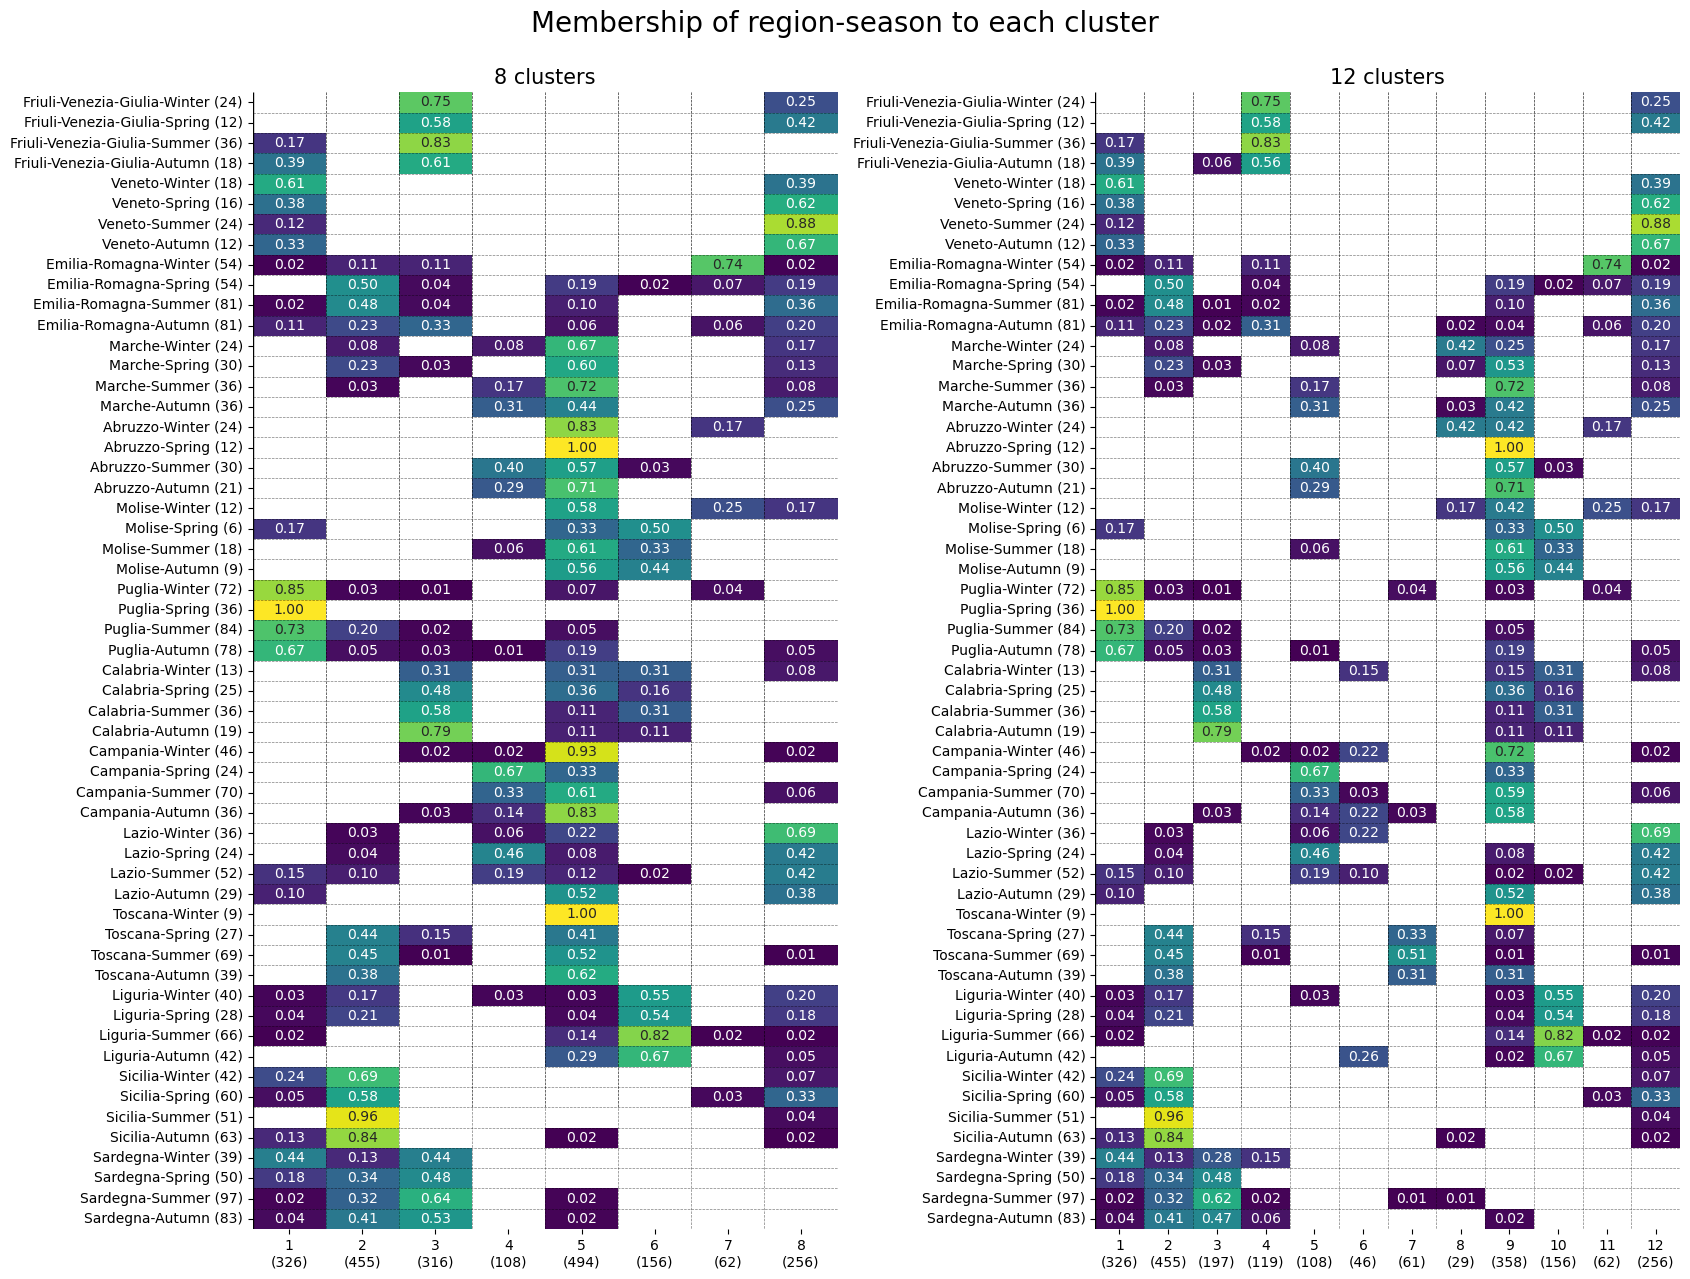

In [51]:
plot_region_season_membership(abund_method_3, methods = ["ward_8", "ward_12"])

In [52]:
326 + 455 + 197 + 119

1097

In [53]:
abund_method_4.drop_duplicates(["Date", "id"])

Date                 id                 Region  Season Det_level  \
0     2015-07-31  0073-MS00370_TR06               Sardegna  Summer     Genus   
35    2015-07-31  0073-MS00370_TR12               Sardegna  Summer     Genus   
79    2015-07-31  0182-MS01070_TR03               Sardegna  Summer     Genus   
119   2015-07-31         ITA06SMLG3  Friuli-Venezia-Giulia  Summer     Genus   
147   2015-07-31             M1CL12               Campania  Summer     Genus   
...          ...                ...                    ...     ...       ...   
18595 2017-12-31             MES030                Liguria  Autumn     Genus   
18607 2017-12-31             MES060                Liguria  Autumn     Genus   
18615 2017-12-31             ORO030                Liguria  Autumn     Genus   
18629 2017-12-31             ORO060                Liguria  Autumn     Genus   
18646 2017-12-31             ORO120                Liguria  Autumn     Genus   

                   Class          Genus               Taxon  Longitude  \
0      Bacillariophyceae    Chaetoceros    Chaetoceros spp.    9.81515   
35     Bacillariophyceae    Chaetoceros    Chaetoceros spp.    9.94486   
79     Bacillariophyceae    Chaetoceros    Chaetoceros spp.    8.39275   
119    Bacillariophyceae    Chaetoceros    Chaetoceros spp.   13.31760   
147    Bacillariophyceae       Navicula       Navicula spp.   15.12050   
...                  ...            ...                 ...        ...   
18595  Bacillariophyceae  Cylindrotheca  Cylindrotheca spp.    9.58118   
18607  Bacillariophyceae  Thalassionema  Thalassionema spp.    9.54118   
18615  Bacillariophyceae  Cylindrotheca  Cylindrotheca spp.    9.13399   
18629  Bacillariophyceae    Chaetoceros    Chaetoceros spp.    9.10440   
18646  Bacillariophyceae    Chaetoceros    Chaetoceros spp.    9.04561   

       Latitude  ...  ward_12  ward_13  ward_14  ward_15  ward_16  ward_17  \
0       39.9503  ...        9       10       11       12       12       12   
35      39.9505  ...        9       10       11       12       12       12   
79      40.8882  ...        9        9       10       11       11       11   
119     45.5503  ...       10       11       12       13       13       14   
147     39.8986  ...        9       10       11       12       12       12   
...         ...  ...      ...      ...      ...      ...      ...      ...   
18595   44.1011  ...        1        1        1        1        1        1   
18607   44.0605  ...        1        1        1        1        1        1   
18615   44.2711  ...        1        1        1        2        2        2   
18629   44.2260  ...        1        1        1        1        1        1   
18646   44.1365  ...        1        1        1        1        1        1   

       ward_18  ward_19  ward_20     Month  
0           13       13       14      July  
35          13       13       14      July  
79          11       11       12      July  
119         15       15       16      July  
147         13       13       14      July  
...        ...      ...      ...       ...  
18595        1        1        1  December  
18607        1        1        1  December  
18615        2        2        2  December  
18629        1        1        1  December  
18646        1        1        1  December  

[670 rows x 33 columns]

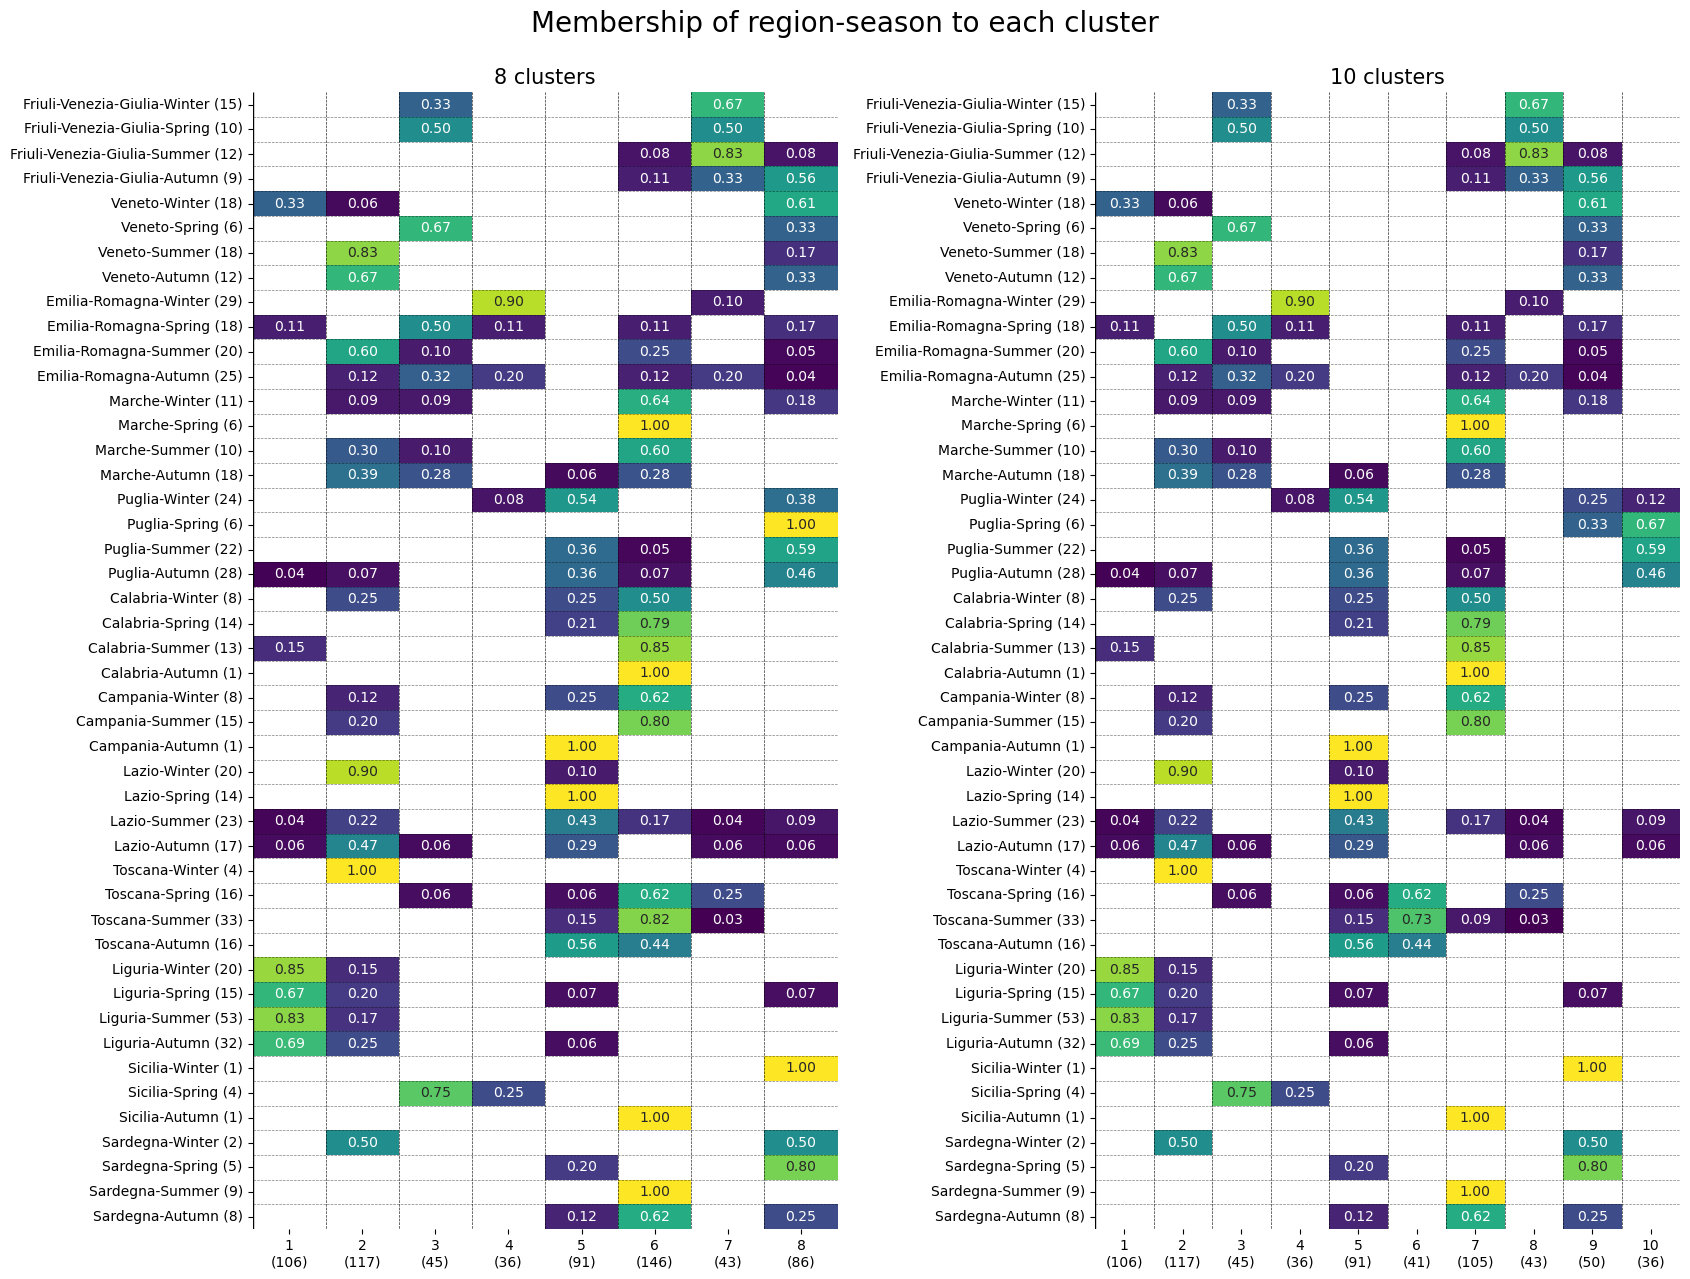

In [183]:
plot_region_season_membership(abund_method_4, methods = ["ward_8", "ward_10"])

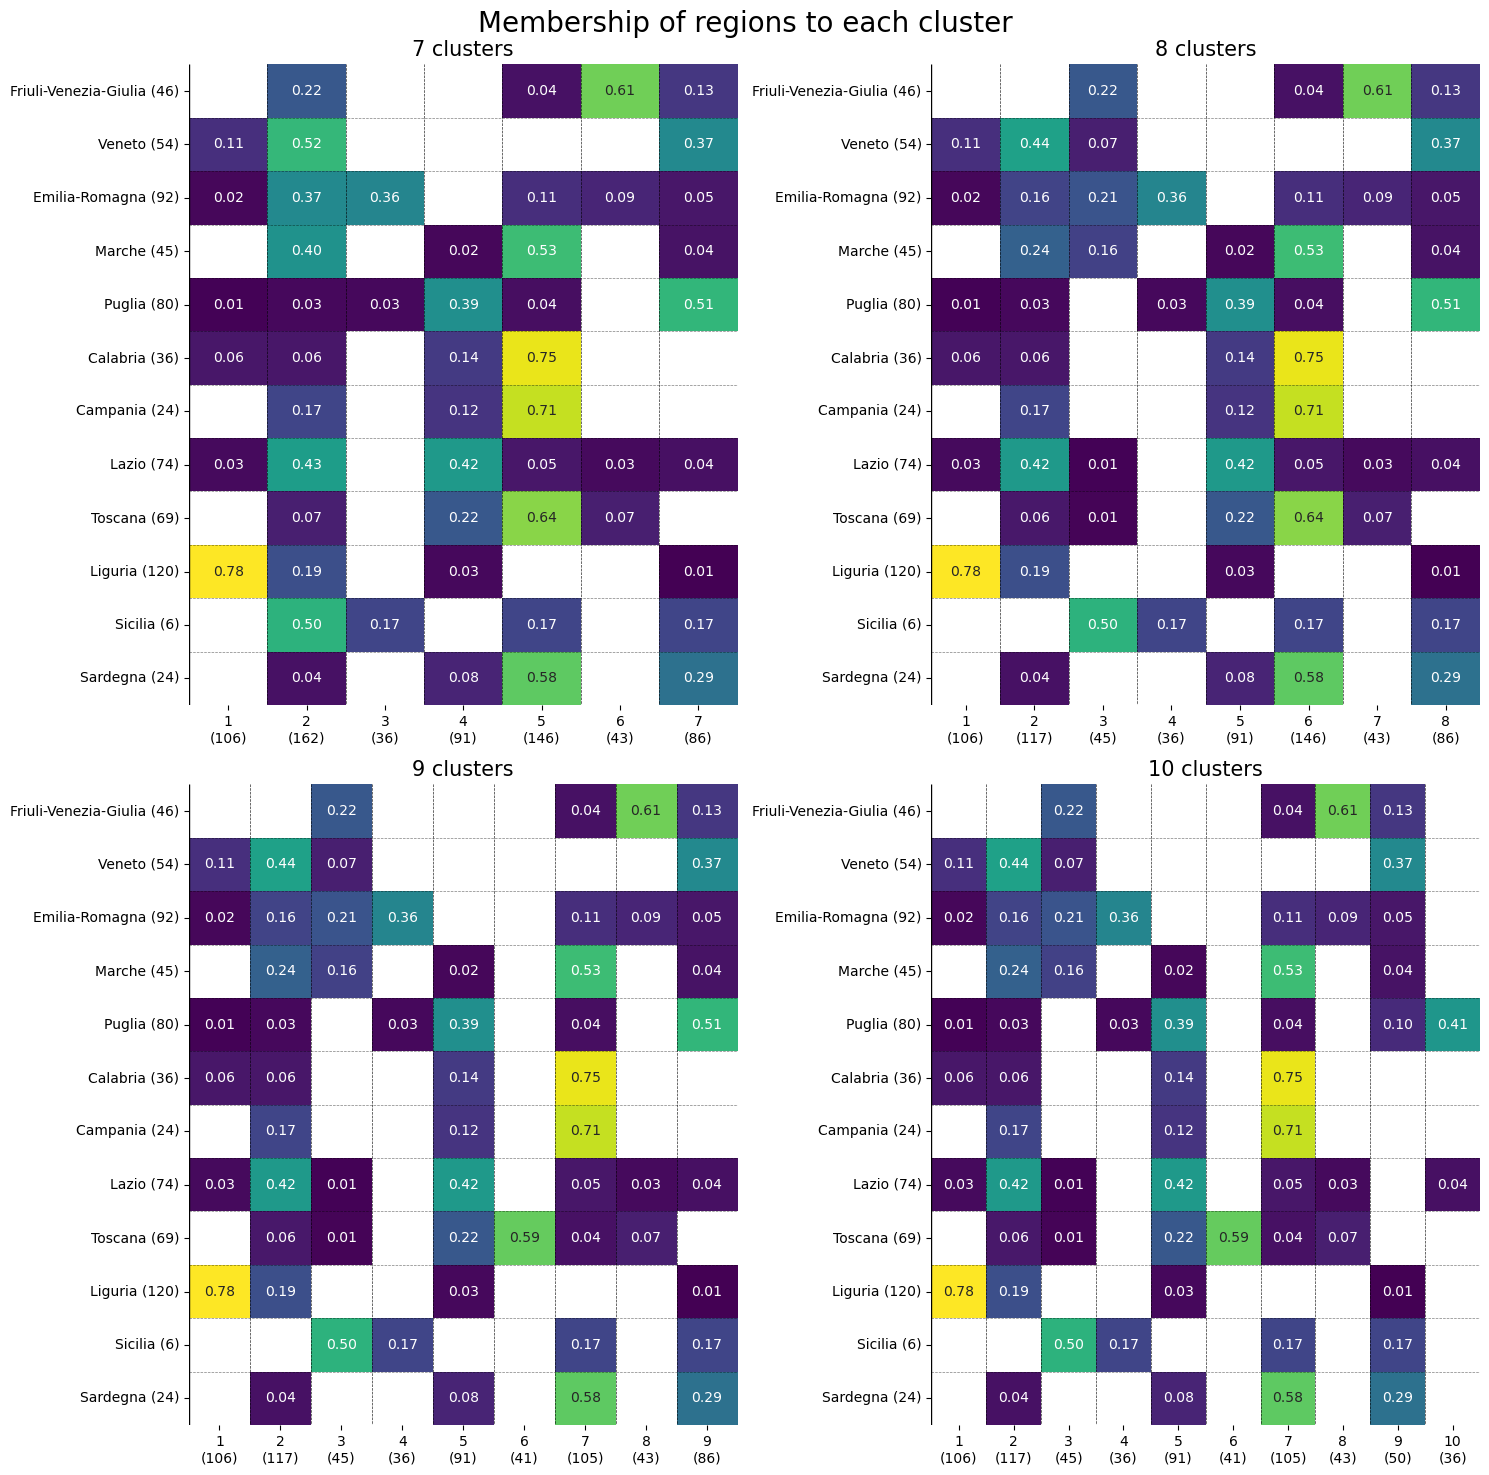

In [215]:
plot_region_membership(abund_method_4)